In [ ]:
import json          
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
import sys
from pathlib import Path
from rich.console import Console                                                                                                                                        
import warnings
import canonical_toolkit as ctk
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
DATA_FOLDER = None
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
warnings.filterwarnings("ignore", message="n_jobs value.*overridden.*")                                       
console = Console()                                                                                           
                                                                                                            
# Step out of analysis/ folder first                                                                          
base_folder = Path.cwd().parent                                                                               
                                                                                                            
# 1. Check if DATA_FOLDER is already set                                                                      
if DATA_FOLDER:                                                                                               
    data_path = Path(DATA_FOLDER)                                                                             
    ea_folder = data_path.parent.parent  # __data__/run_xxx -> ea/                                            
                                                                                                            
# 2. Try to find run_history.csv in parent (ea/ folder)                                                       
elif (base_folder / "run_history.csv").exists():                                                              
    df = pd.read_csv(base_folder / "run_history.csv")                                                         
    data_path = base_folder / df["output_folder"].iloc[-1]                                                    
    ea_folder = base_folder                                                                                   
                                                                                                            
# 3. Assume notebook is inside output_folder/analysis/, walk up to find config.py                             
else:                                                                                                         
    ea_folder = base_folder                                                                                   
    while ea_folder != ea_folder.parent:                                                                      
        if (ea_folder / "config.py").exists():                                                                
            break                                                                                             
        ea_folder = ea_folder.parent                                                                          
    else:                                                                                                     
        raise FileNotFoundError("Could not find ea/config.py in any parent directory")                        
    data_path = base_folder  # output_folder is parent of analysis/                                           
                                                                                                            
sys.path.insert(0, str(ea_folder.parent))                                                                     
from ea.config import Config                                                                                  
                                                                                                            
print(data_path)                                                                                              
data = pd.read_sql("SELECT * FROM individual", sqlite3.connect(data_path / "database.db"))                    
config = Config.load(data_path)                                                                               
config.large_description()

Loading BokehJS ...

__data__/run_0010/


In [ ]:
archive = ctk.SimilarityArchive.load(
    frame_folder_path=f"{config.OUTPUT_FOLDER}/feature_frames",
    db_file_path=f"{config.OUTPUT_FOLDER}/database.db"
)

In [4]:
tags_expanded = data['tags_'].apply(lambda x: json.loads(x) if isinstance(x, str) else x).apply(pd.Series)                                        
data = pd.concat([data, tags_expanded], axis=1)                                                                                                   
                                                                                                                                                                                                                                                     
data['gen'] = data.apply(                                                                                                                         
    lambda row: list(range(int(row['time_of_birth']), int(row['time_of_death']) + 1)),                                                            
    axis=1                                                                                                                                        
)

In [5]:
gen_df = (data                                                                                                                                                     
    .explode('gen')                                                                                                                                                
    .rename(columns={'fitness_': 'fitness', 'genotype_': 'genotype', 'tags_': 'tags'})                                                                             
    .sort_values(['gen', 'ctk_string'], ascending=[True, True])                                                                                                    
)                                                                                                                                                                                                                                                               
gen_df['rank'] = gen_df.groupby('gen').cumcount()                                                                                                                  
gen_df = gen_df.set_index(['gen', 'rank'])

survivors_df = gen_df.reset_index()
survivors_df = survivors_df[survivors_df['time_of_death'] > survivors_df['gen']]
survivors_df = survivors_df.set_index(['gen', 'rank'])

In [6]:
survivors_df.head()

id  alive  time_of_birth  time_of_death  requires_eval   fitness  \
gen rank                                                                     
0   0      2      1              0              2              0  0.753727   
    1      4      0              0              1              0  0.727372   
    2      1      1              0              2              0  0.843795   
    3      3      0              0              1              0  0.727372   
1   1      2      1              0              2              0  0.753727   

          requires_init                                           genotype  \
gen rank                                                                     
0   0                 0  [[-6180.734035370213, 5424.950020094462, -5680...   
    1                 0  [[6710.103963588197, 1427.4386417578899, 5738....   
    2                 0  [[4488.495899540903, -1001.4156431023748, 5875...   
    3                 0  [[-2025.7263864901433, 7972.971232040092, 3567...   
1   1                 0  [[-6180.734035370213, 5424.950020094462, -5680...   

                                                       tags  \
gen rank                                                      
0   0     {"ctk_string": "C[f(B4[b(B2[b(B1H6H5H4H4HH4)]B...   
    1     {"ctk_string": "C[f(B6[l(B6[b(B6[t(B)l(B2B)b(B...   
    2     {"ctk_string": "C[f(H5H4H6)]<b(B5[l(B[l(B2[r(B...   
    3     {"ctk_string": "C[f(H7B[r(B1)b(B4)l(B5[r(B3[l(...   
1   1     {"ctk_string": "C[f(B4[b(B2[b(B1H6H5H4H4HH4)]B...   

                                                 ctk_string  \
gen rank                                                      
0   0      C[f(B4[b(B2[b(B1H6H5H4H4HH4)]B6[t(B1H6H6H2)])])]   
    1     C[f(B6[l(B6[b(B6[t(B)l(B2B)b(B7)]H5H5H7)]B2H6)...   
    2     C[f(H5H4H6)]<b(B5[l(B[l(B2[r(B7)])t(B3H4)r(B6H...   
    3     C[f(H7B[r(B1)b(B4)l(B5[r(B3[l(B6[b(B6H4)]B1H2H...   
1   1      C[f(B4[b(B2[b(B1H6H5H4H4HH4)]B6[t(B1H6H6H2)])])]   

                                                      image   novelty  
gen rank                                                               
0   0     data:image/webp;base64,UklGRj4DAABXRUJQVlA4WAo...  0.753727  
    1     data:image/webp;base64,UklGRh4DAABXRUJQVlA4WAo...  0.727372  
    2     data:image/webp;base64,UklGRmYCAABXRUJQVlA4WAo...  0.843795  
    3     data:image/webp;base64,UklGRgYDAABXRUJQVlA4WAo...  0.727372  
1   1     data:image/webp;base64,UklGRj4DAABXRUJQVlA4WAo...  0.753727

In [7]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot_generation = config.NUM_GENERATIONS-1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

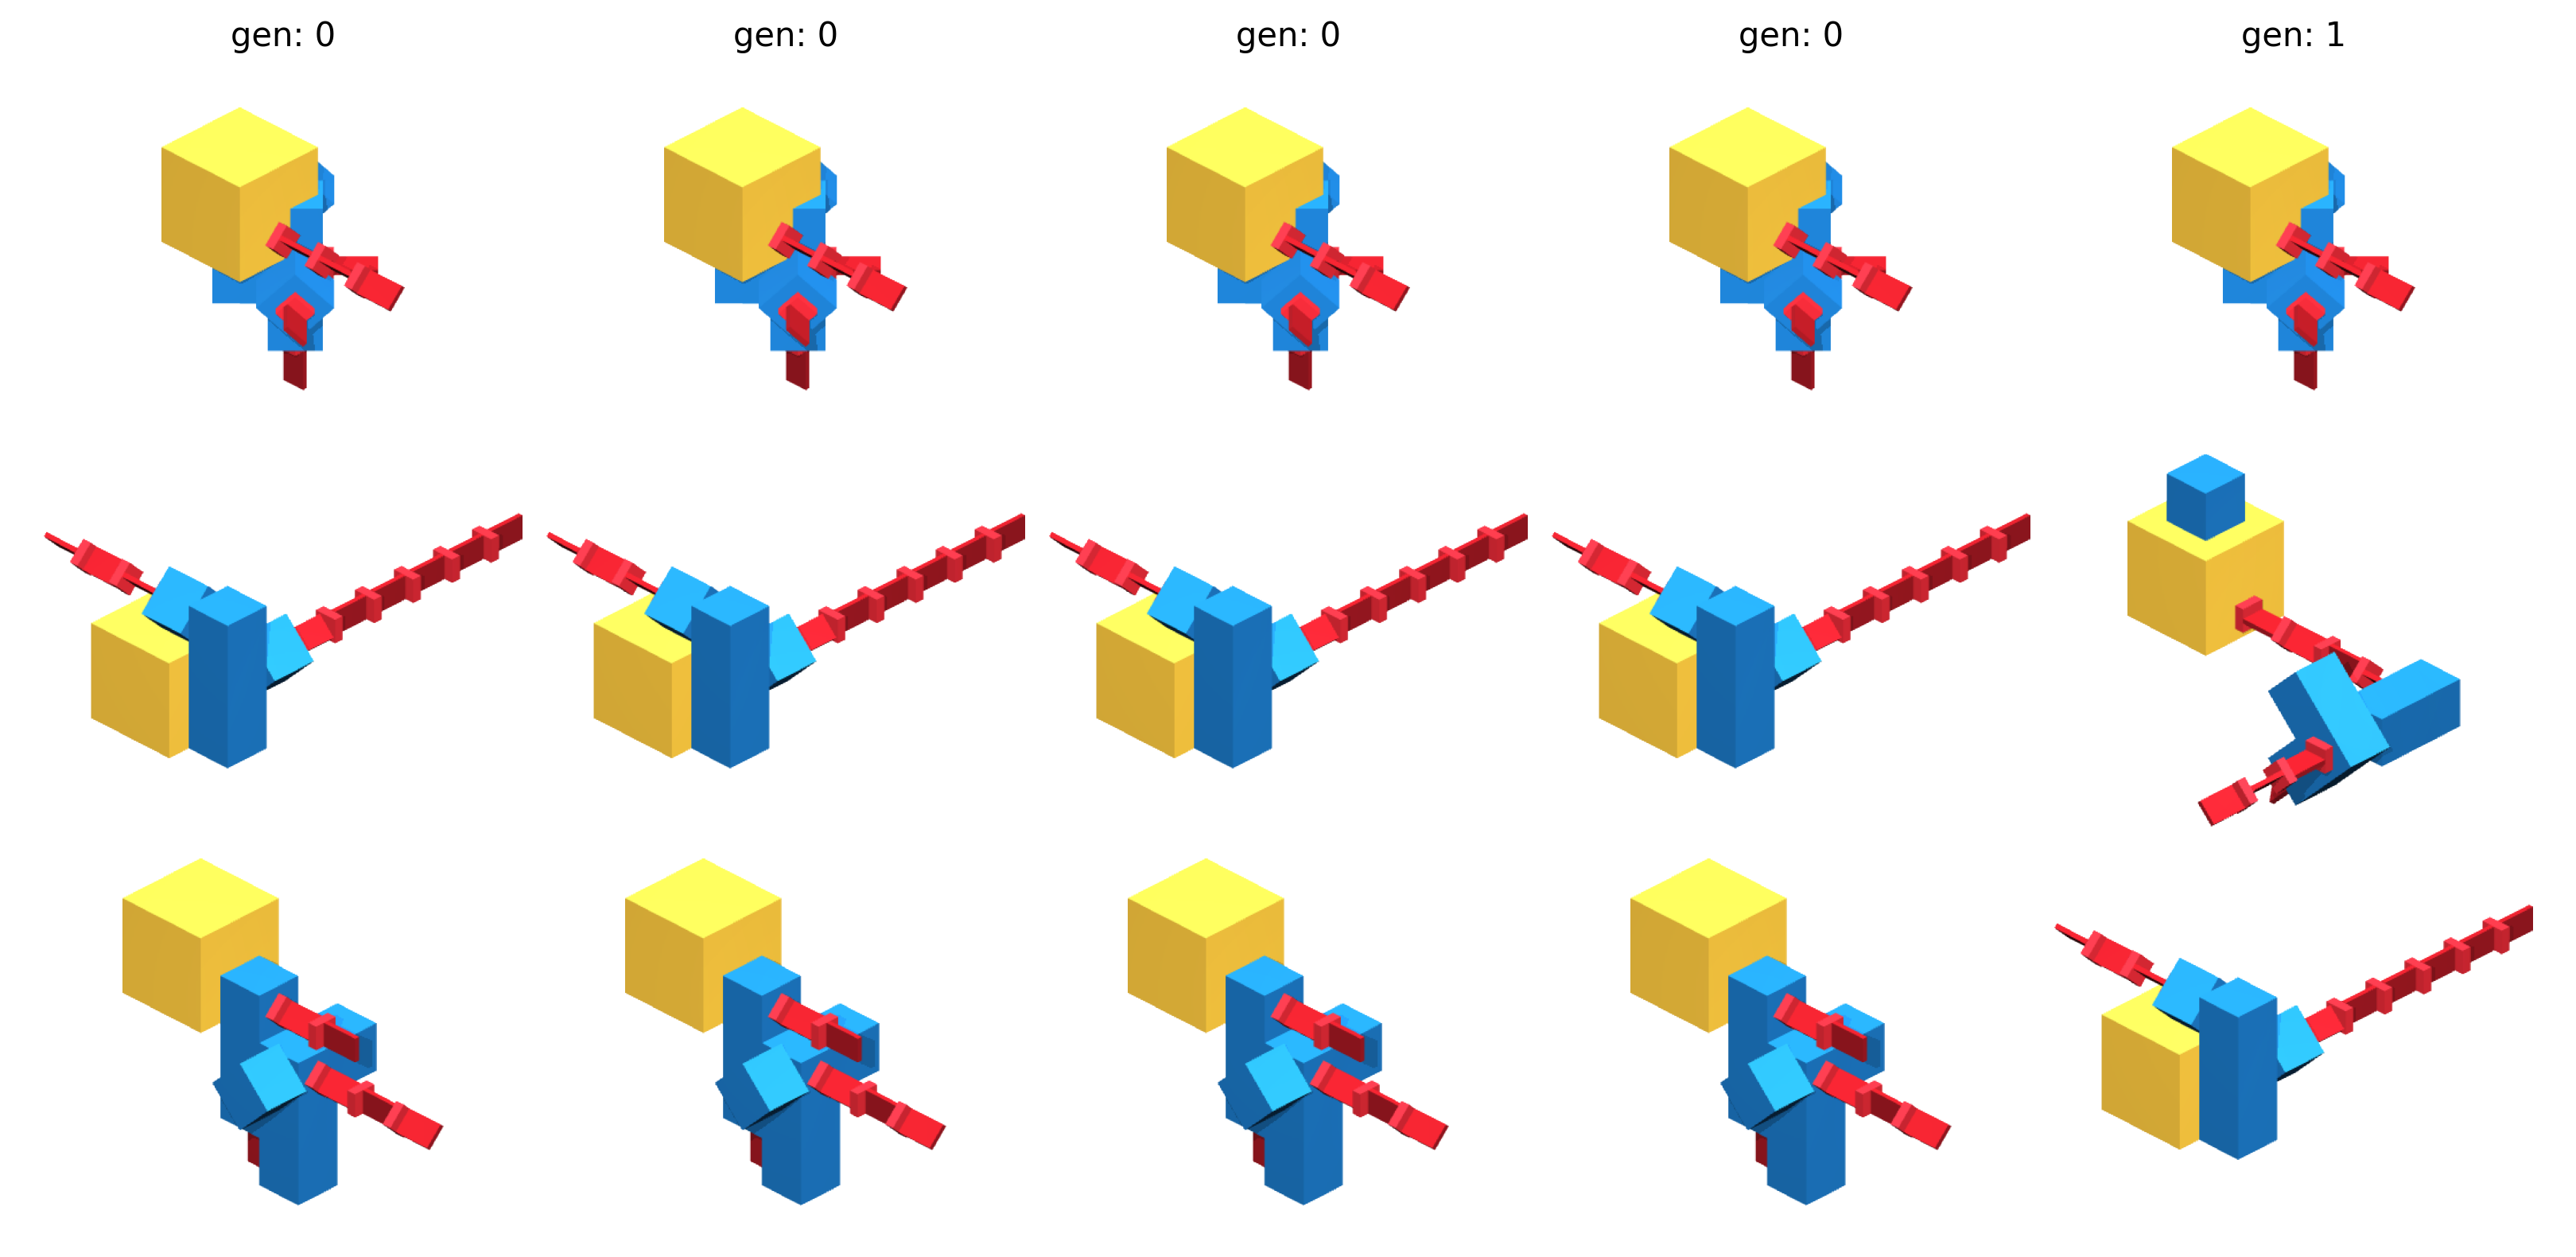

In [8]:
amt = 3
n_samples = 5
sample_gens = np.linspace(0, config.NUM_GENERATIONS - 1, n_samples, dtype=int)
ascending = not config.IS_MAXIMISATION

grid = [[
    ctk.quick_view(ctk.node_from_string(
        survivors_df.loc[g].sort_values('fitness', ascending=ascending).iloc[i].ctk_string
    ).to_graph(), return_img=True, white_background=True) 
    for g in sample_gens] for i in range(amt)
]

plotter = ctk.GridPlotter(n_rows=amt, n_cols=n_samples)
plotter.add_2D_image_data(grid)
[plotter[0, i].set_title(f"gen: {g}") for i, g in zip(range(n_samples), sample_gens)]
plotter.show()

In [ ]:
amt = 100

last_gen = config.NUM_GENERATIONS - 1
ascending = not config.IS_MAXIMISATION
last_gen_df = survivors_df.loc[last_gen].sort_values('fitness', ascending=ascending).head(amt)
images = []
for i in range(amt):
    ind = last_gen_df.iloc[i]
    img = ctk.quick_view(
        ctk.node_from_string(ind.ctk_string).to_graph(), 
        return_img=True, 
        white_background=True
    )
    images.append(img)
   
plotter = ctk.GridPlotter()
plotter.add_image_data(images, shape=(5,20))
# [plotter[0, i].set_title(f"gen: {g}") for i, g in zip(range(n_samples), sample_gens)]
plotter.show()

In [9]:
alive = archive.alive_only(inplace=False)


### HEATMAPS

1 GEN (START), all r, all spaces

In [10]:
cosine = alive.map('cosine_similarity', inplace=False)

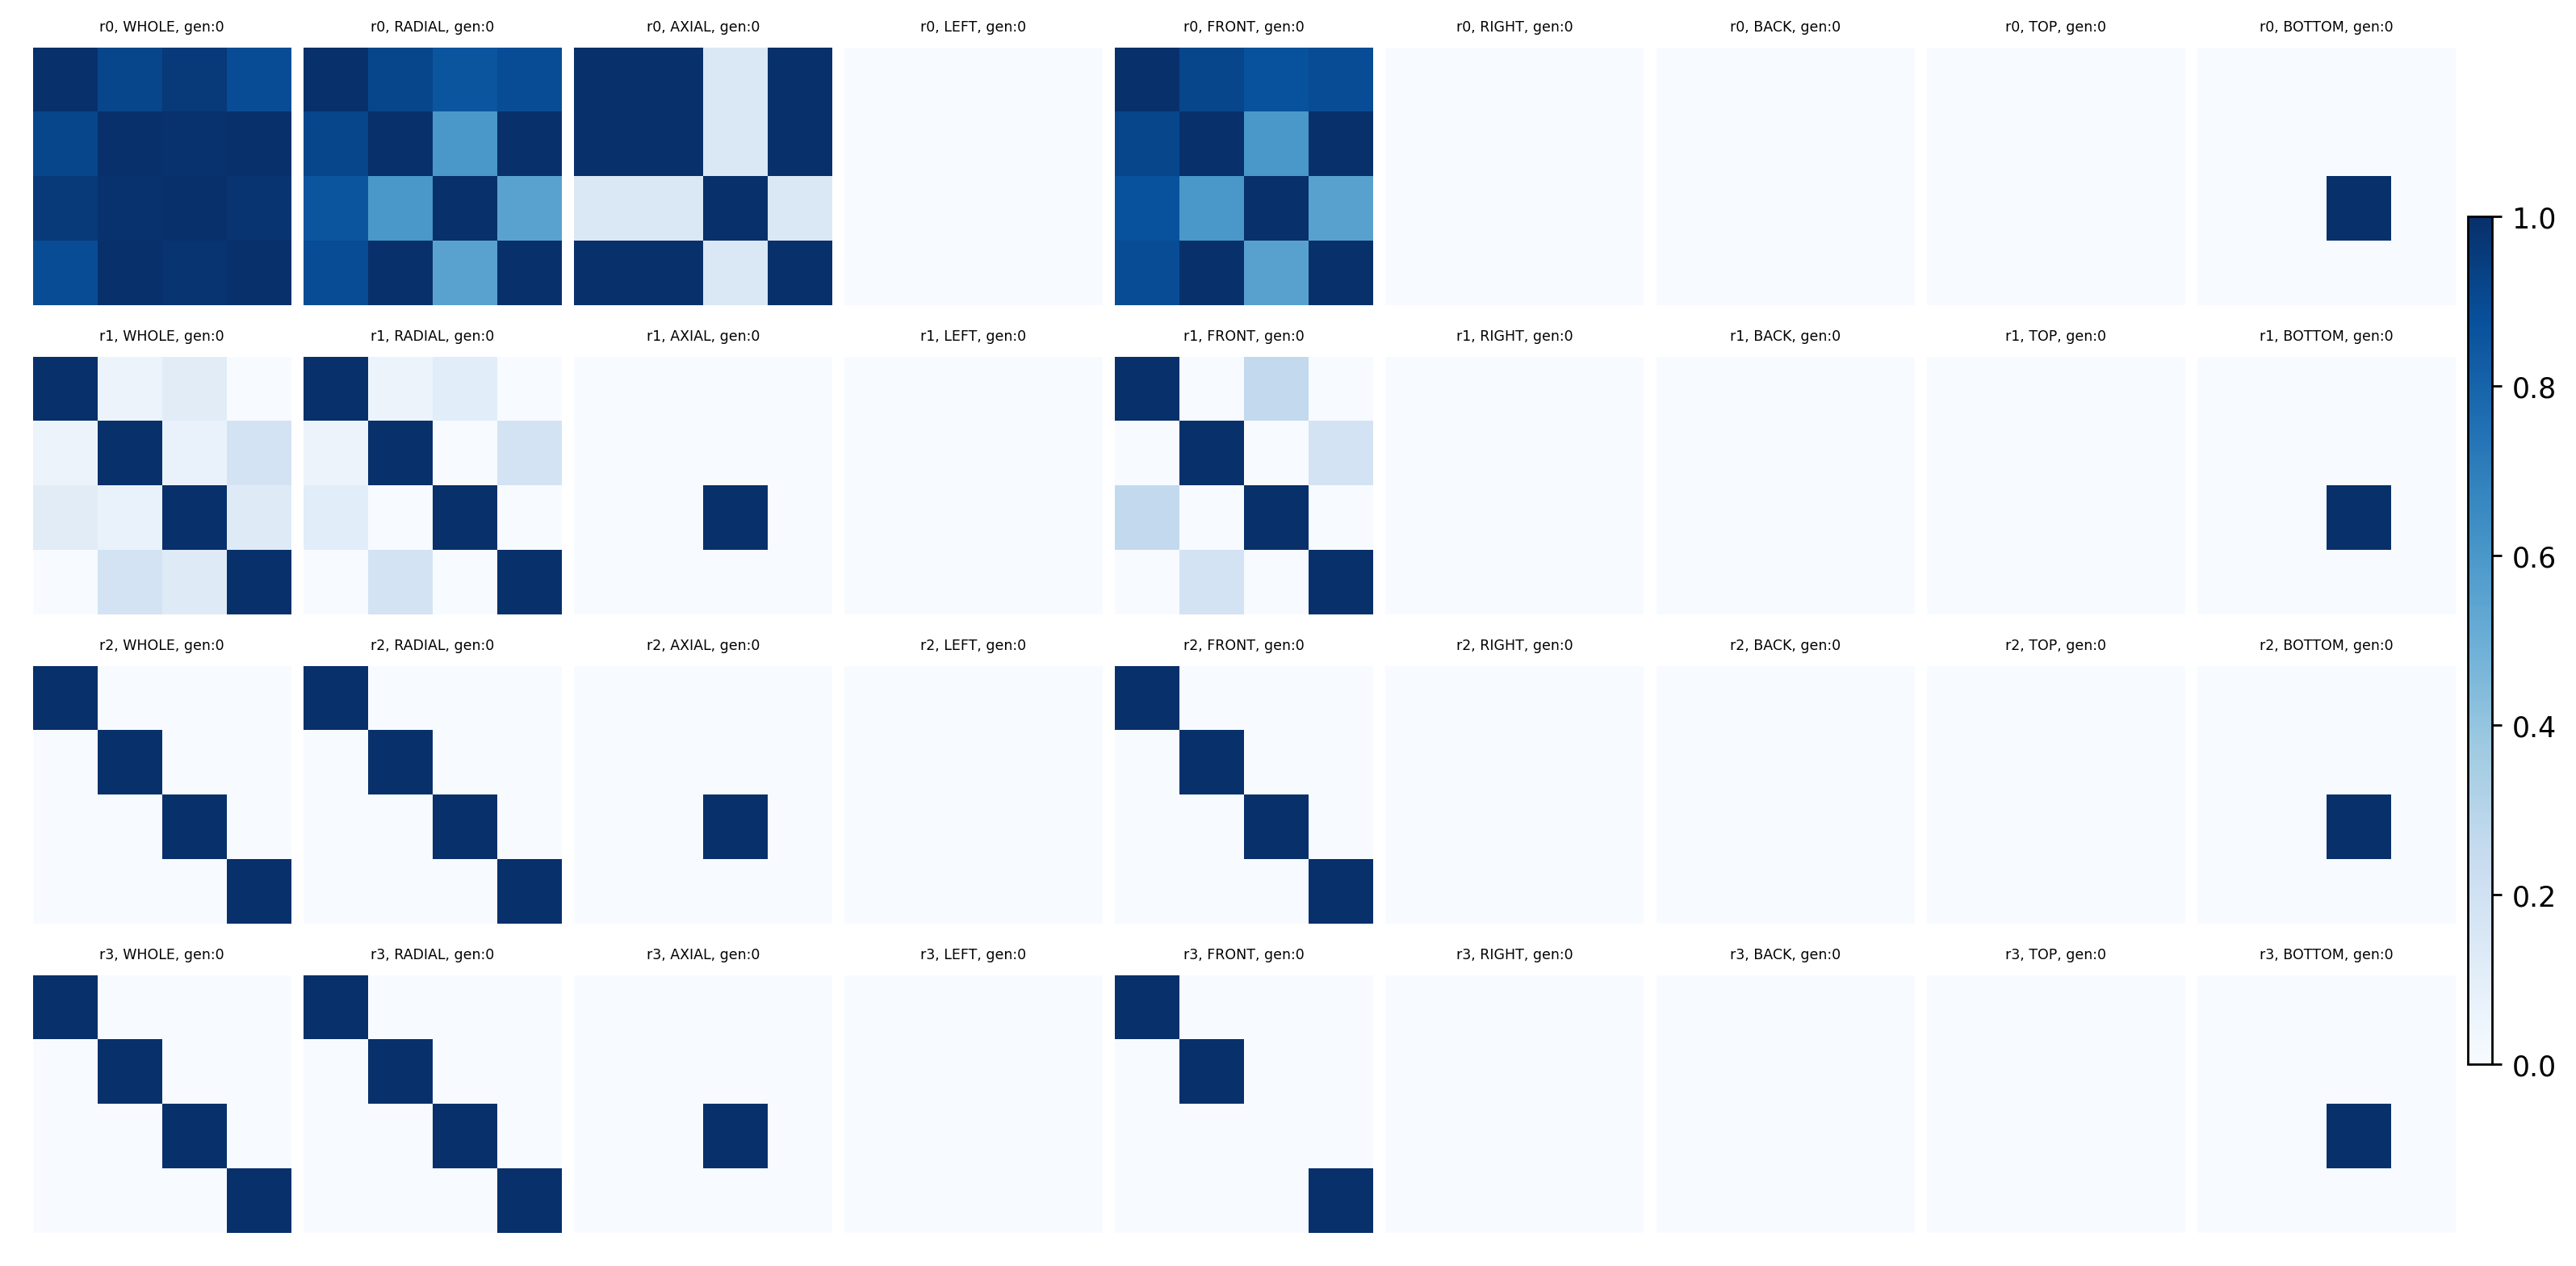

In [11]:
heatmap_plot = cosine[0]

heatmap_plotter = ctk.GridPlotter()
heatmap_plotter.add_2D_numeric_data(
    data_2d=heatmap_plot.get_2d_data(), 
    titles_2d=heatmap_plot.get_2d_titles(),
    cmap="Blues"
)
heatmap_plotter.config.col_space = 0.05
heatmap_plotter.config.row_space = 0.2
heatmap_plotter.add_global_colorbar("right")
heatmap_plotter.transpose()
heatmap_plotter.show()

1 GEN (end), all r, all spaces

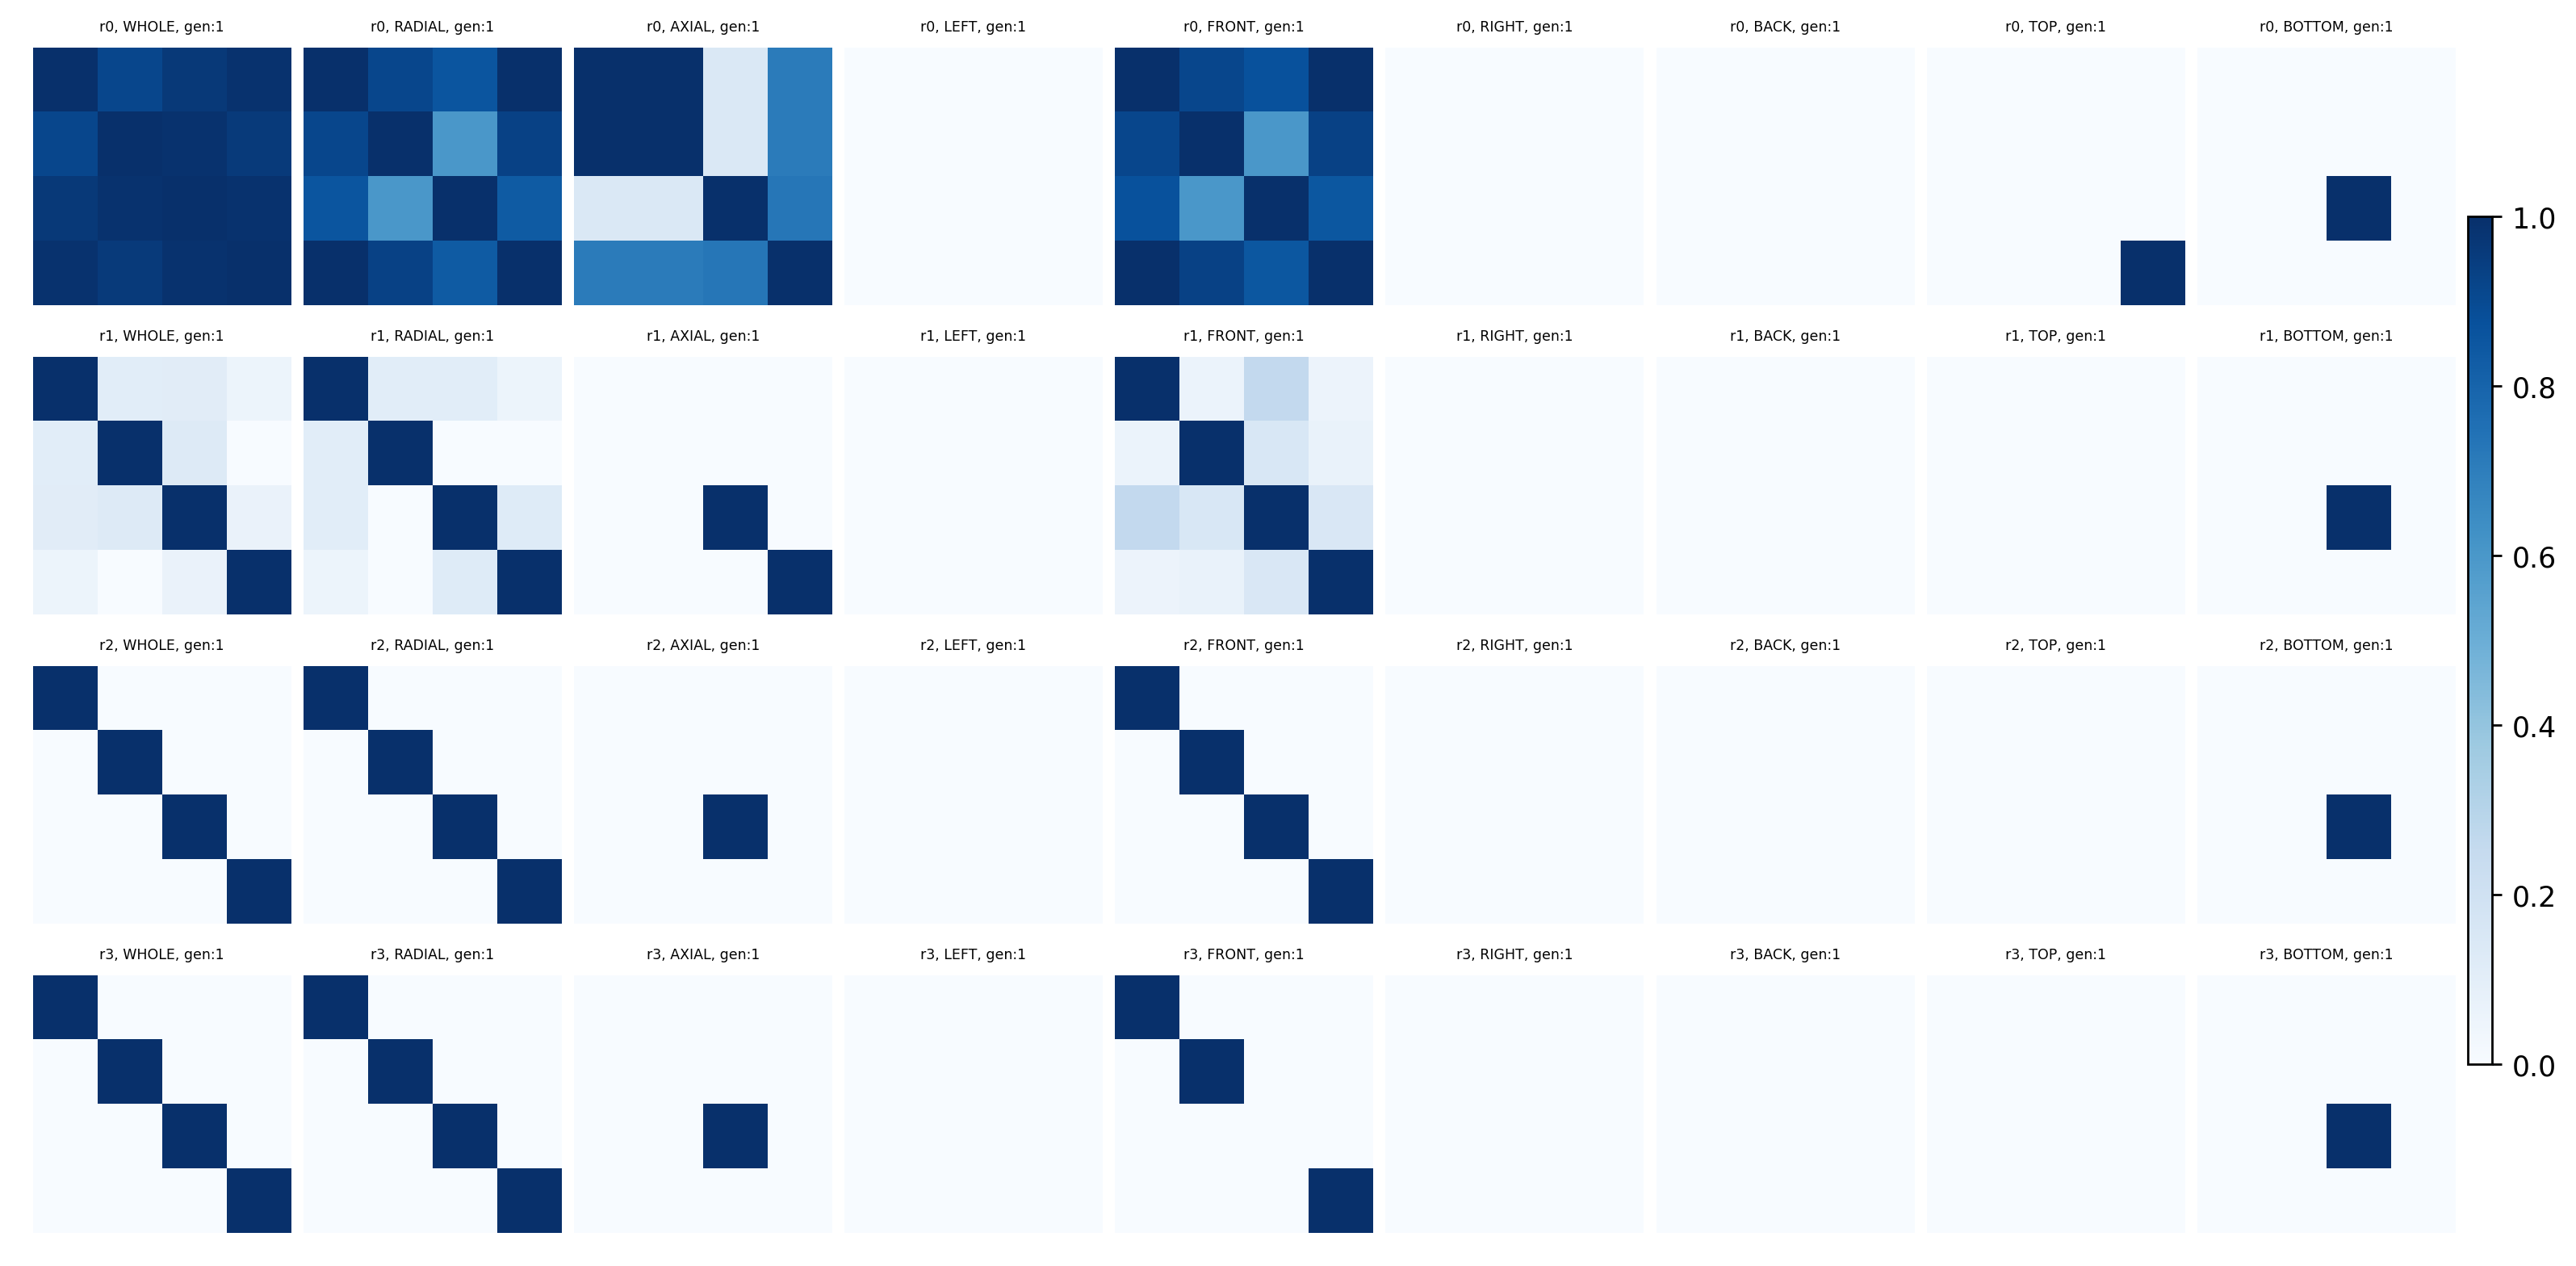

In [12]:
heatmap_plot = cosine[-1]


heatmap_plotter = ctk.GridPlotter()
heatmap_plotter.add_2D_numeric_data(
    data_2d=heatmap_plot.get_2d_data(), 
    titles_2d=heatmap_plot.get_2d_titles(),
    cmap="Blues"
)
heatmap_plotter.config.col_space = 0.05
heatmap_plotter.config.row_space = 0.2
heatmap_plotter.add_global_colorbar("right")
heatmap_plotter.transpose()
heatmap_plotter.show()

1 RADIUS [pick], all spaces, show evolution

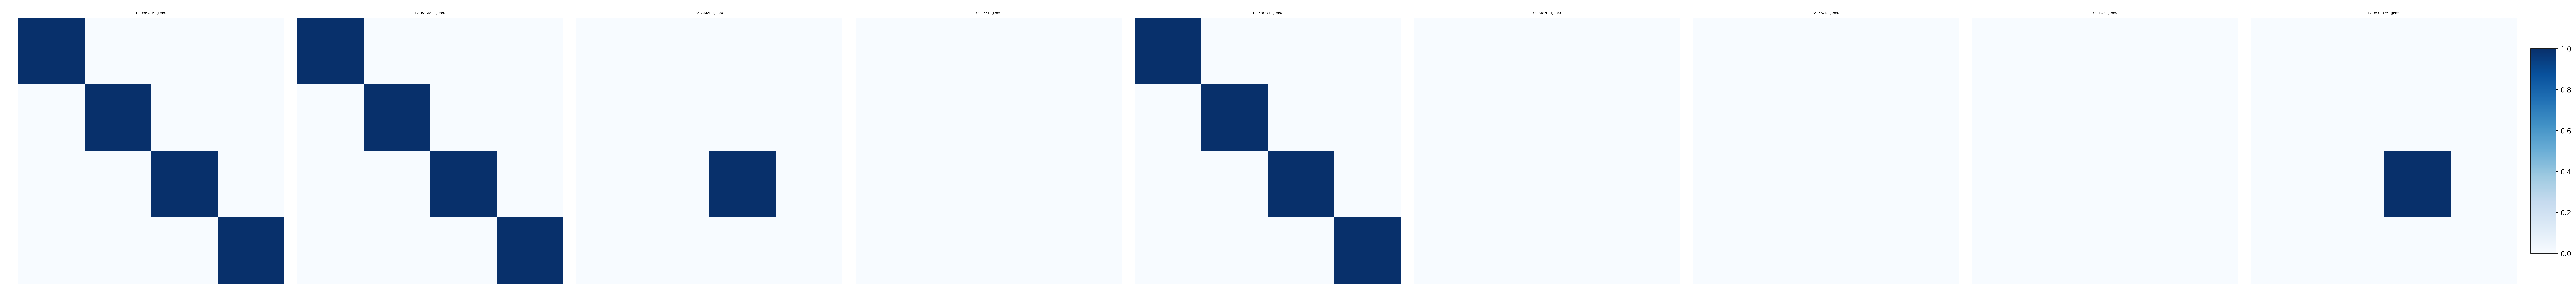

In [13]:
heatmap_plot = cosine[2, :, ::5]


heatmap_plotter = ctk.GridPlotter()
heatmap_plotter.add_2D_numeric_data(
    data_2d=heatmap_plot.get_2d_data(), 
    titles_2d=heatmap_plot.get_2d_titles(),
    cmap="Blues"
)
heatmap_plotter.config.col_space = 0.05
heatmap_plotter.config.row_space = 0.2
heatmap_plotter.add_global_colorbar("right")
heatmap_plotter.transpose()
heatmap_plotter.show()

### r [CUMUL]

In [14]:
cumul_cosine = cosine.map('to_cumulative', inplace=False)

1 GEN (start), all r [CUMUL], all spaces

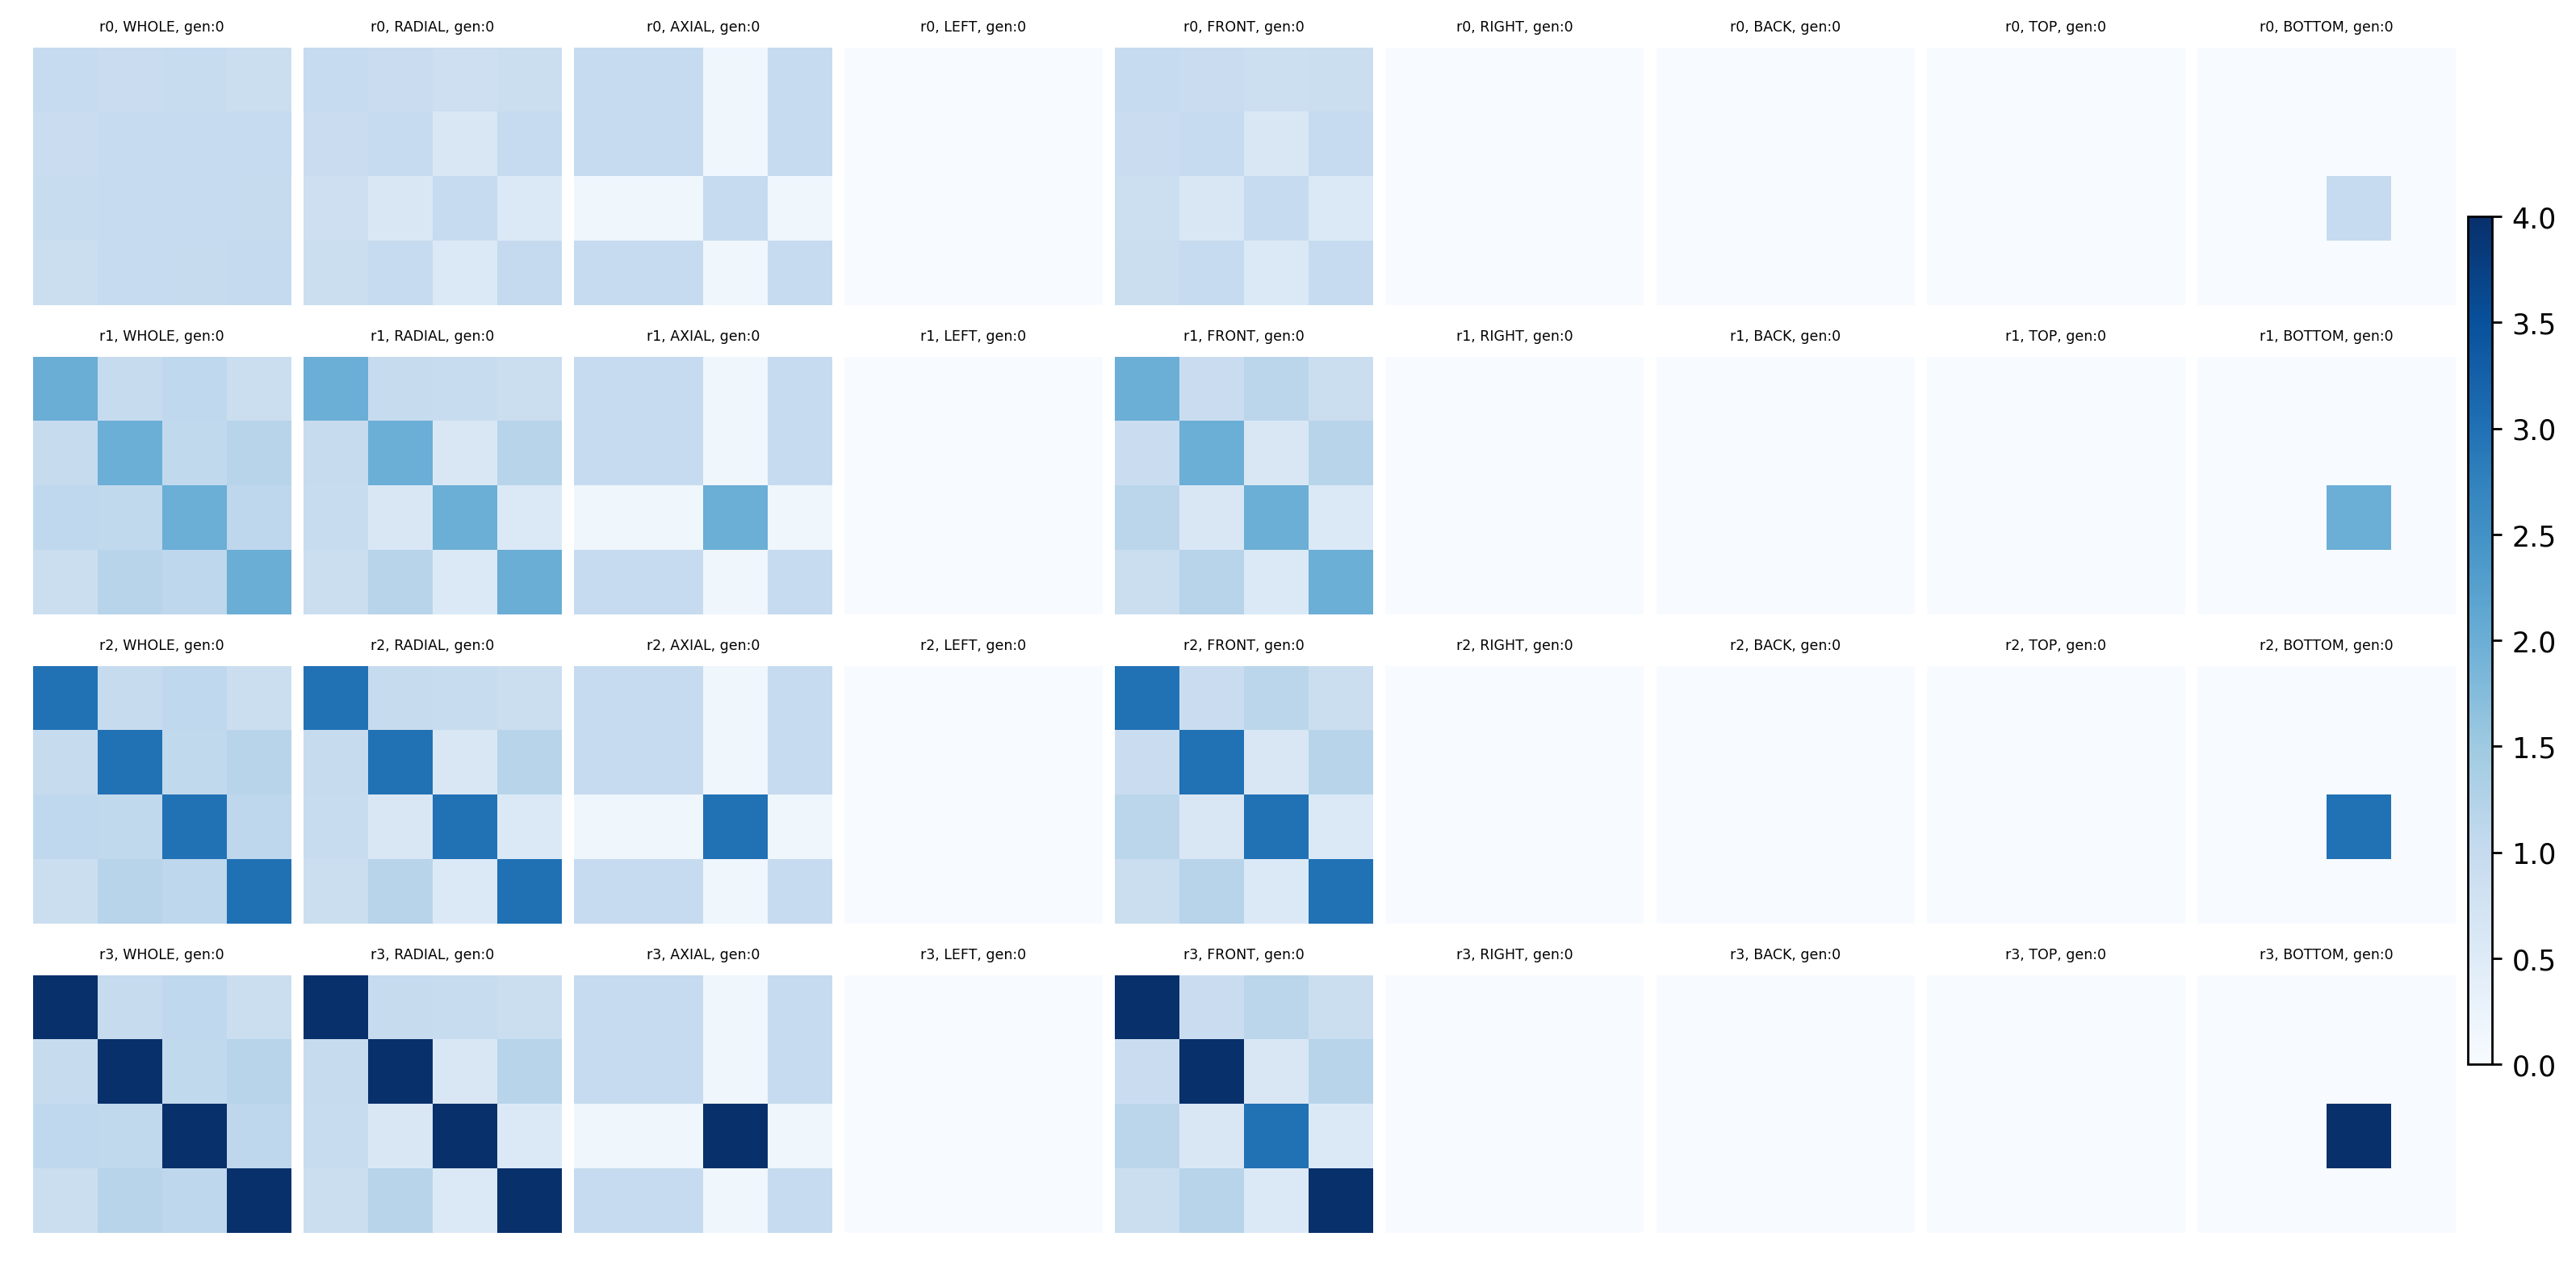

In [15]:
heatmap_plot = cumul_cosine[0]


heatmap_plotter = ctk.GridPlotter()
heatmap_plotter.add_2D_numeric_data(
    data_2d=heatmap_plot.get_2d_data(), 
    titles_2d=heatmap_plot.get_2d_titles(),
    cmap="Blues"
)
heatmap_plotter.config.col_space = 0.05
heatmap_plotter.config.row_space = 0.2
heatmap_plotter.add_global_colorbar("right")
heatmap_plotter.transpose()
heatmap_plotter.show()

1 GEN (end), all r [CUMUL], all spaces

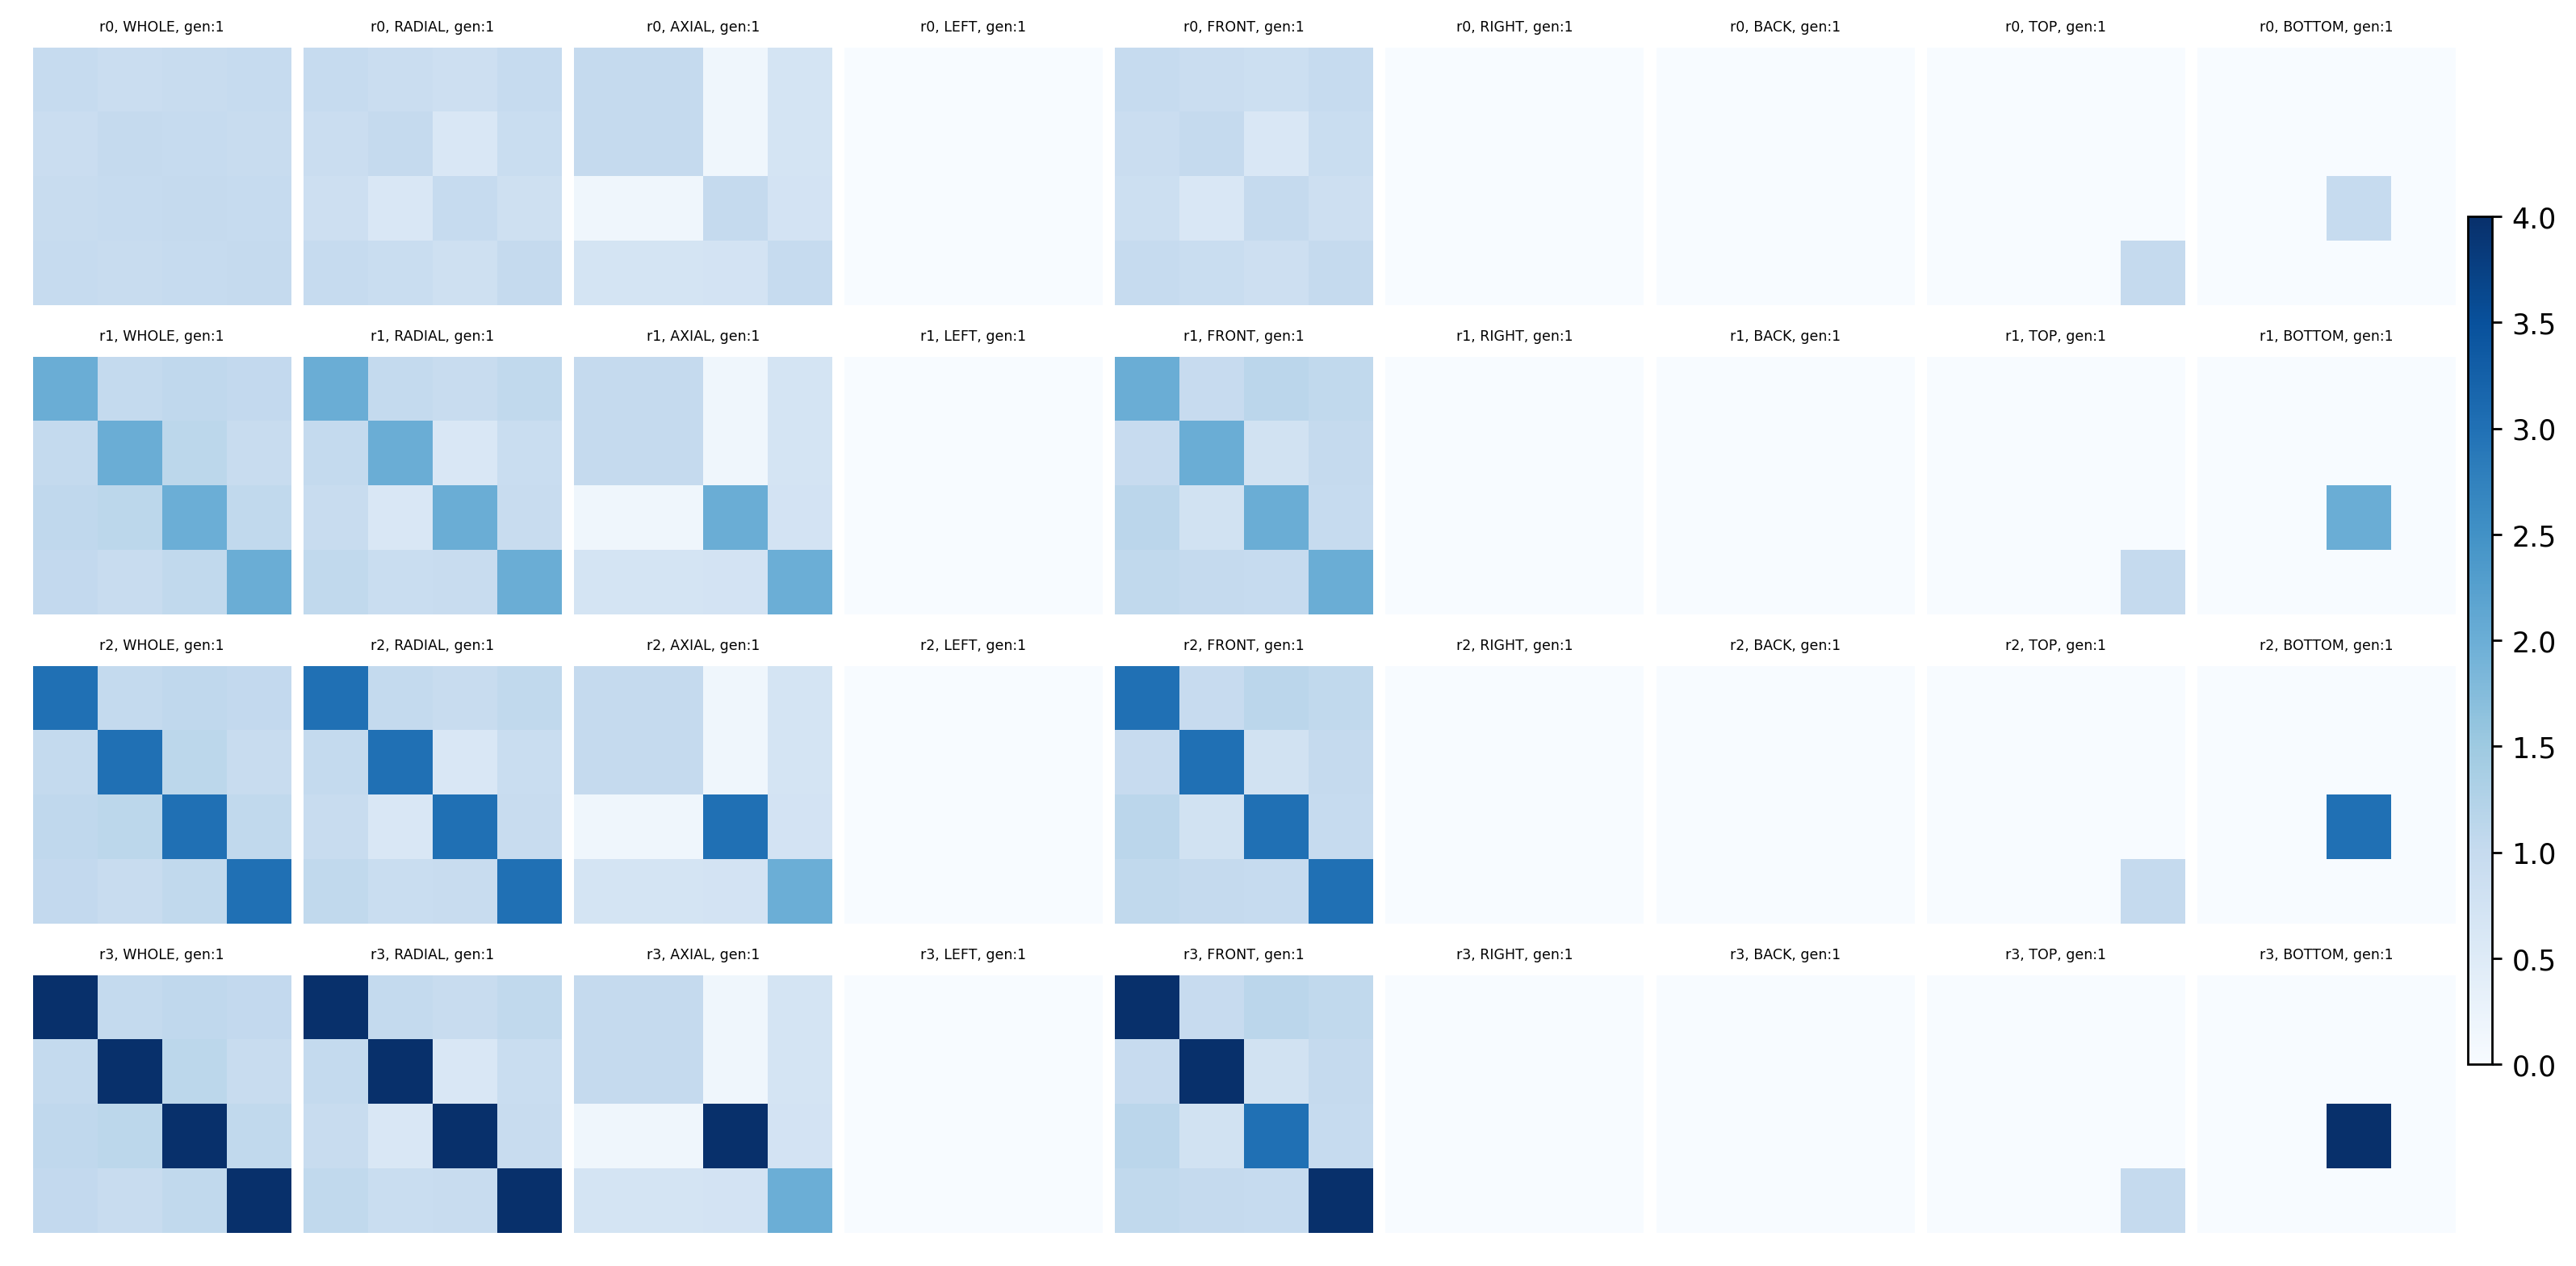

In [16]:
heatmap_plot = cumul_cosine[-1]


heatmap_plotter = ctk.GridPlotter()
heatmap_plotter.add_2D_numeric_data(
    data_2d=heatmap_plot.get_2d_data(), 
    titles_2d=heatmap_plot.get_2d_titles(),
    cmap="Blues"
)
heatmap_plotter.config.col_space = 0.05
heatmap_plotter.config.row_space = 0.2
heatmap_plotter.add_global_colorbar("right")
heatmap_plotter.transpose()
heatmap_plotter.show()

1 RADIUS [CUMUL] [pick], all spaces, show evolution

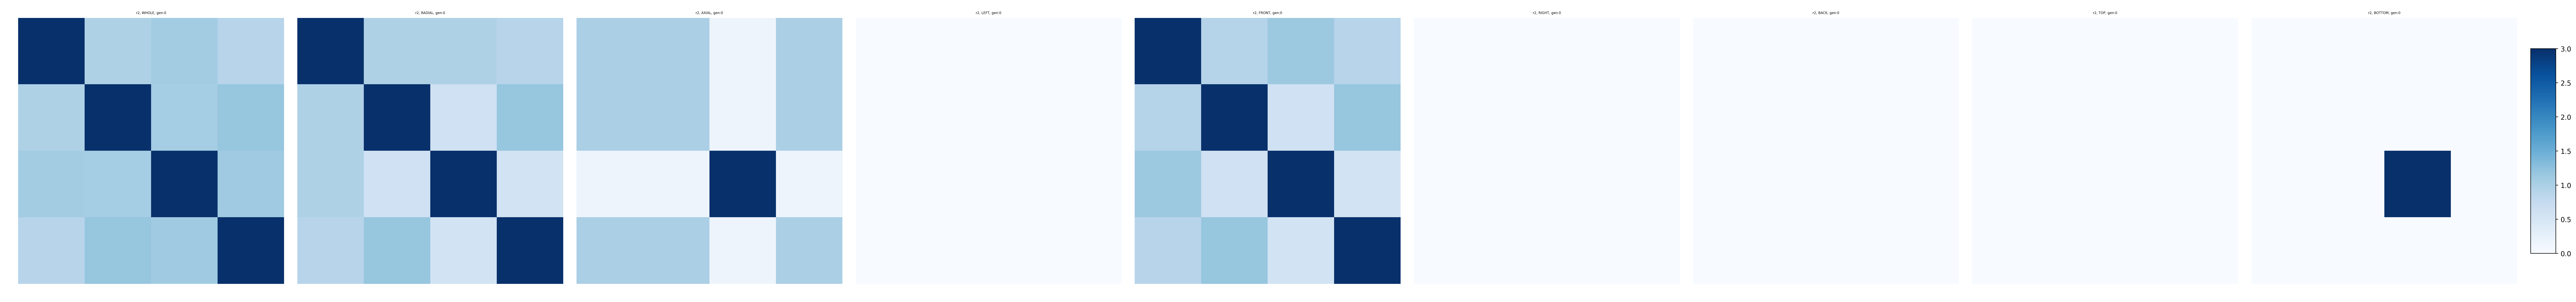

In [17]:
heatmap_plot = cumul_cosine[2, :, ::5]

heatmap_plotter = ctk.GridPlotter()
heatmap_plotter.add_2D_numeric_data(
    data_2d=heatmap_plot.get_2d_data(), 
    titles_2d=heatmap_plot.get_2d_titles(),
    cmap="Blues"
)
heatmap_plotter.config.col_space = 0.05
heatmap_plotter.config.row_space = 0.2
heatmap_plotter.add_global_colorbar("right")
heatmap_plotter.transpose()
heatmap_plotter.show()

### r [CUMUL] space [CUMUL]

In [18]:
cumul_cumul_cosine = cumul_cosine.map('to_cumulative', inplace=False)

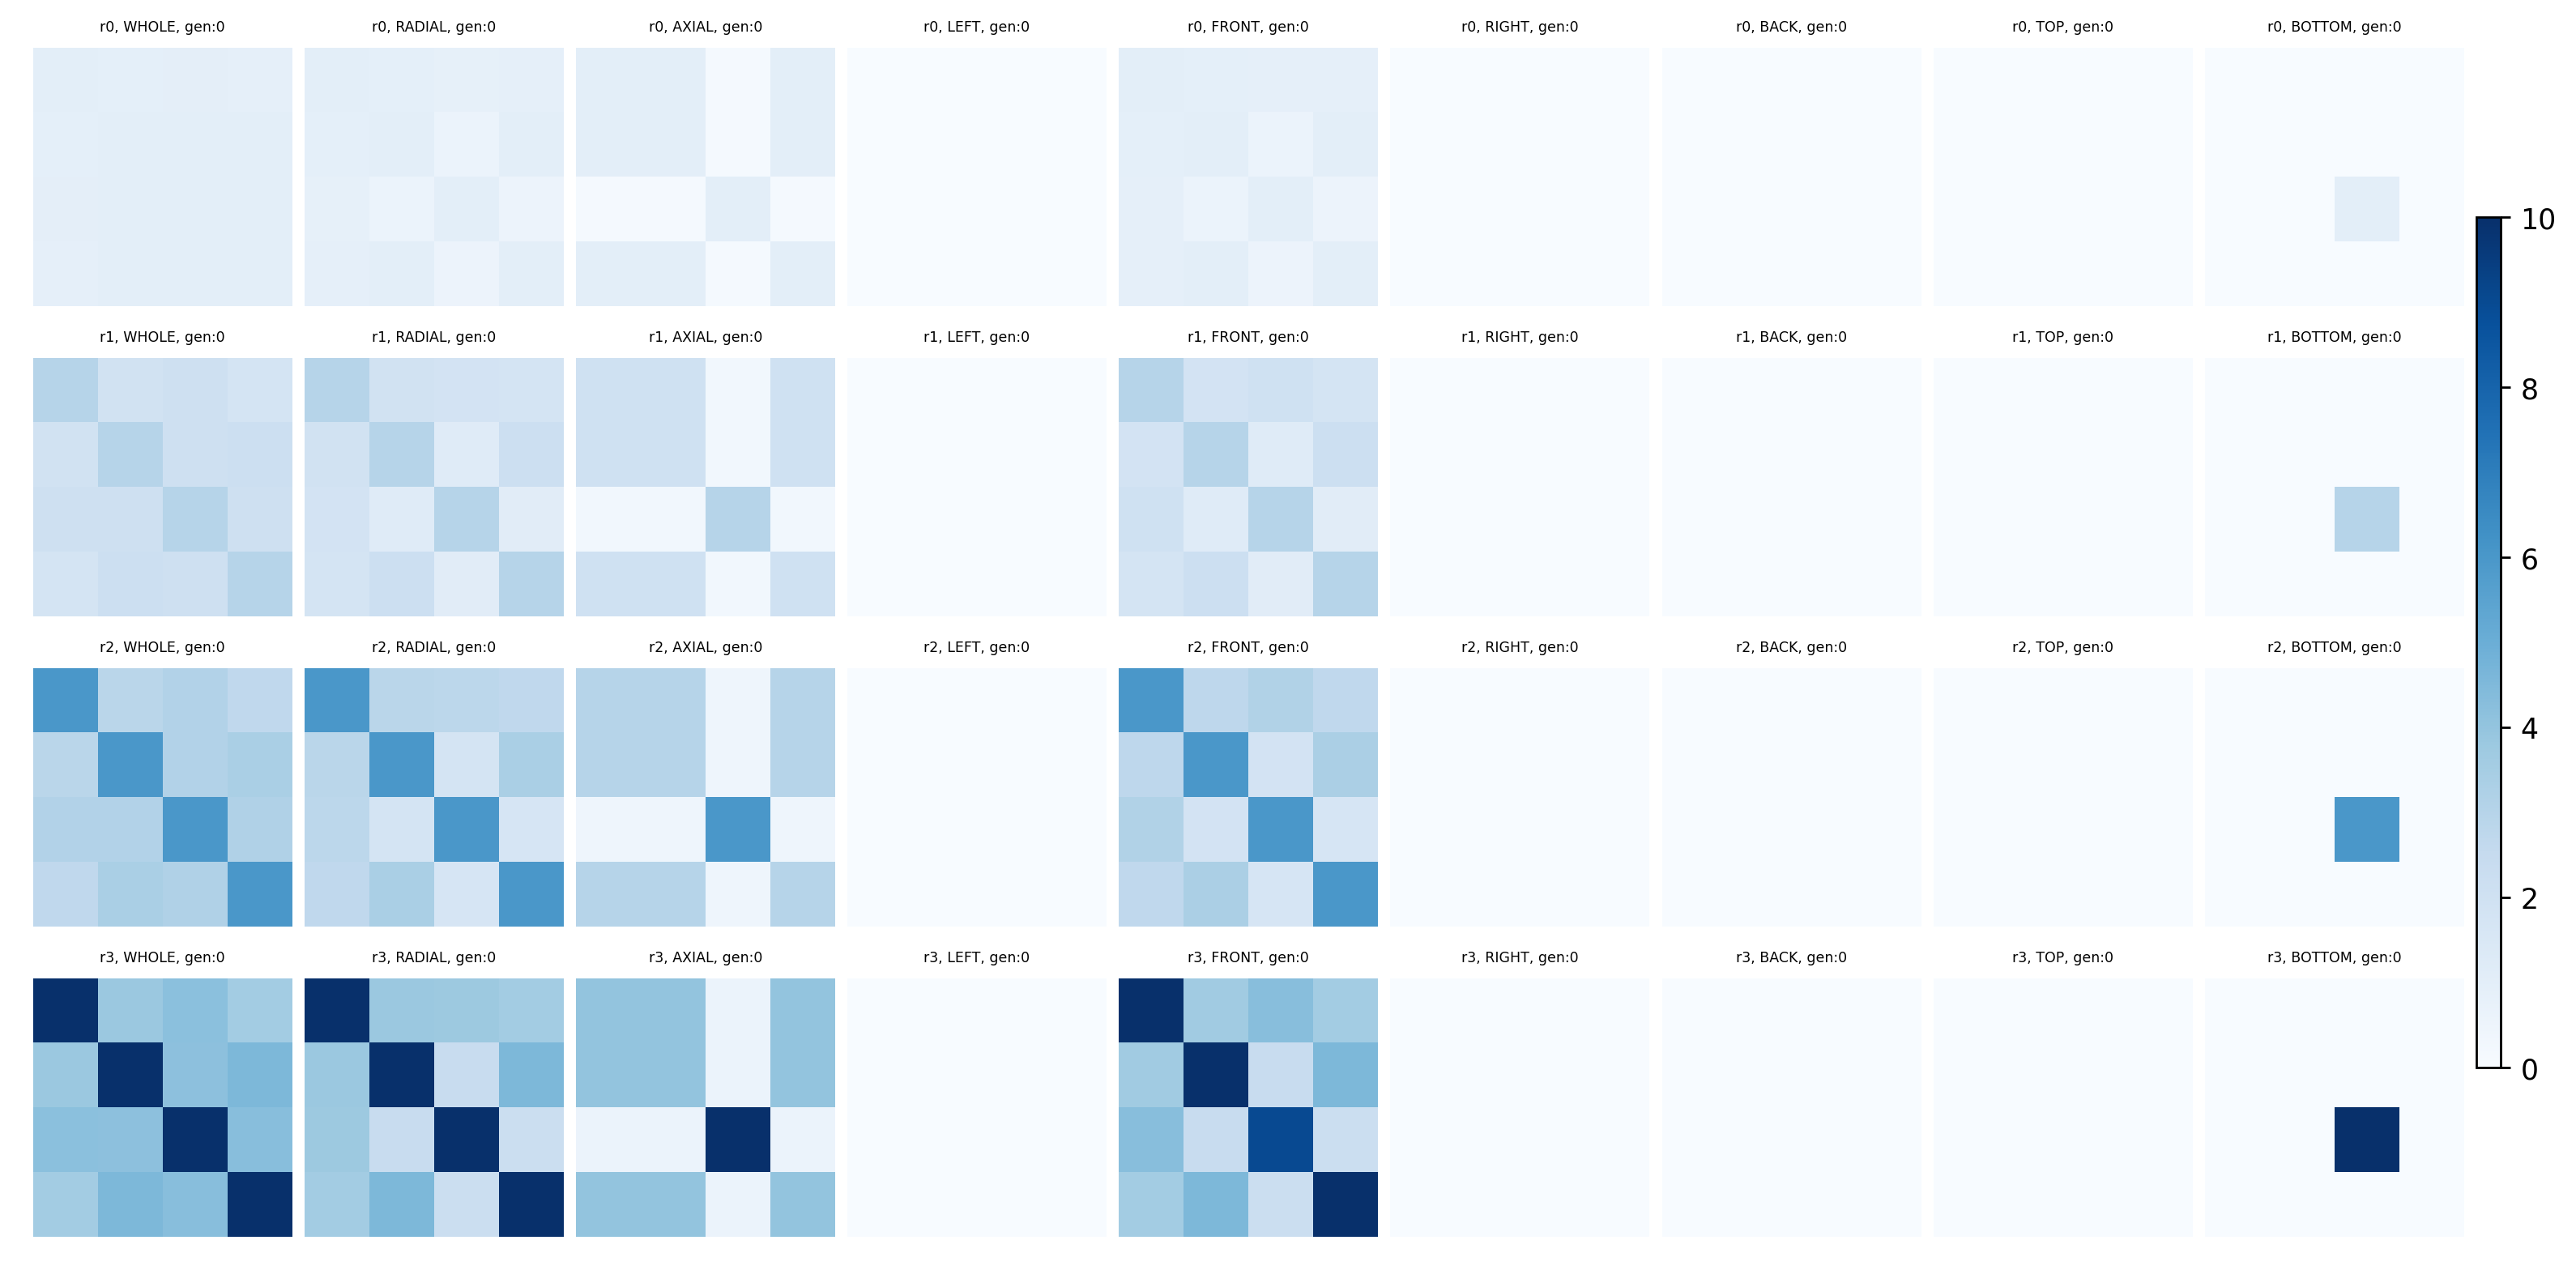

In [19]:
heatmap_plot = cumul_cumul_cosine[:, :, ::5]

heatmap_plotter = ctk.GridPlotter()
heatmap_plotter.add_2D_numeric_data(
    data_2d=heatmap_plot.get_2d_data(), 
    titles_2d=heatmap_plot.get_2d_titles(),
    cmap="Blues"
)
heatmap_plotter.config.col_space = 0.05
heatmap_plotter.config.row_space = 0.2
heatmap_plotter.add_global_colorbar("right")
heatmap_plotter.transpose()
heatmap_plotter.show()

---

### Umap Space embeddings

In [20]:
# color prep for dots

df_all = survivors_df.reset_index()
norm = mcolors.Normalize(vmin=df_all.fitness.min(), vmax=df_all.fitness.max())
cmap = plt.get_cmap('RdYlGn')
dot_ids = df_all.id.tolist()
dot_colors = [mcolors.to_hex(cmap(norm(f))) for f in df_all.fitness]
top_5_ids = set(df_all.sort_values('fitness', ascending=False).head(5).id)
dot_sizes = [9 if i in top_5_ids else 4 for i in dot_ids]

In [21]:
to_fit = alive.replace()

grid = ctk.TransformerGrid(to_fit[0].grab_frame().shape)
umap = umap = ctk.UmapConfig(
    n_neighbors=5,
).get_umap()  
print(umap)
grid[:,:] = umap

{'n_neighbors': 5, 'n_components': 2, 'min_dist': 0.0, 'metric': 'cosine', 'random_state': 42, 'init': 'random', 'transform_seed': 42, 'n_jobs': 1}
UMAP(init='random', metric='cosine', min_dist=0.0, n_jobs=1, n_neighbors=5, random_state=42)


In [22]:
subset = to_fit.new_only(inplace=False)
subset.fit_grid(grid)

TransformerGrid(shape=(4, 9))

In [23]:
to_embed = alive.replace()[:, :, ::5]
to_embed.transform_grid(grid)

┏━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ IDX ┃  WHOLE  ┃ RADIAL  ┃  AXIAL  ┃   LEFT   ┃  FRONT  ┃  RIGHT   ┃  BACK   ┃   TOP    ┃ BOTTOM  ┃
┡━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│   0 │  [4×2]  │  [4×2]  │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │
│     │   Dn    │   Dn    │   Dn    │          │   Dn    │          │   Dn    │          │   Dn    │
│   1 │  [4×2]  │  [4×2]  │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │
│     │   Dn    │   Dn    │   Dn    │          │   Dn    │          │   Dn    │          │   Dn    │
│   2 │  [4×2]  │  [4×2]  │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │
│     │   Dn    │   Dn    │   Dn    │          │   Dn    │          │   Dn    │          │   Dn    │
│   3 │  [4×2]  │  [4×2]  │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │ 

1 GEN (START), all r, all spaces

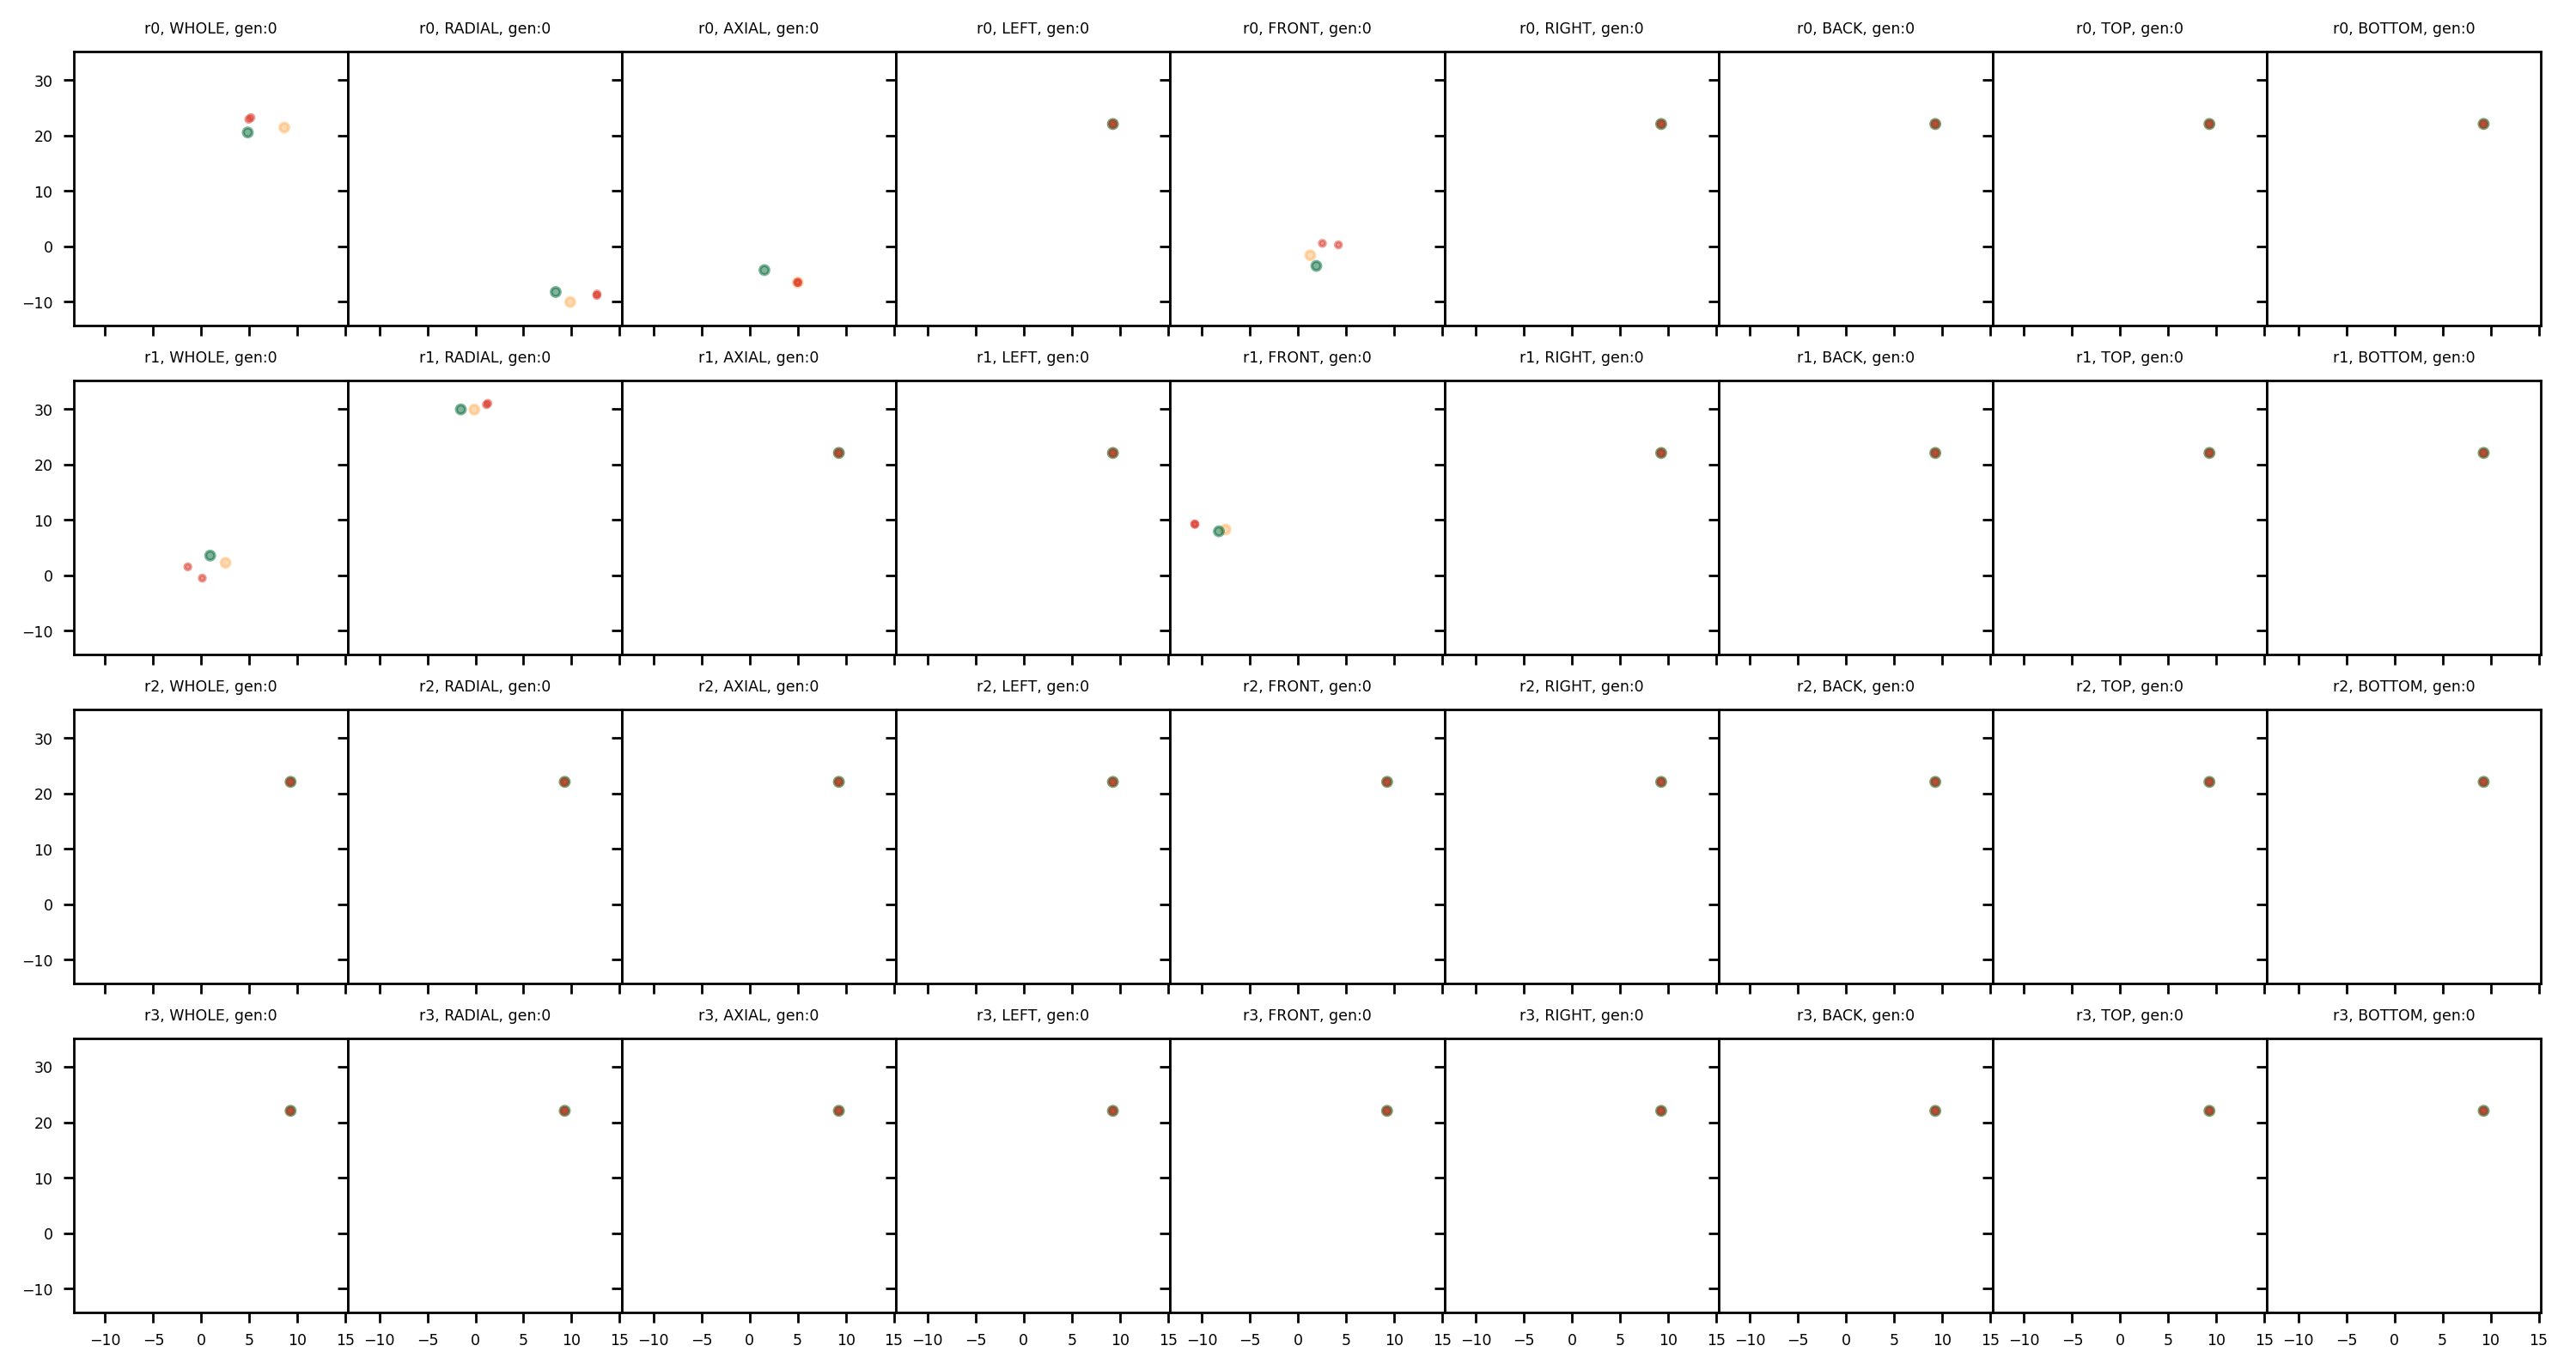

In [24]:
to_plot_embed = to_embed[0]


umap_plotter = ctk.GridPlotter()
umap_plotter.add_2D_numeric_data(
    data_2d=to_plot_embed.get_2d_data(), 
    titles_2d=to_plot_embed.get_2d_titles(),
    global_ids_2d=to_plot_embed.get_2d_ids(),
)
umap_plotter.add_id_styling(ids=dot_ids, colors=dot_colors, sizes=dot_sizes, alphas=[0.5]*len(dot_ids))
umap_plotter.config.col_space = 0
umap_plotter.config.row_space = 0.2
umap_plotter.transpose()
umap_plotter.set_global_axis_limits(padding=0.1)

umap_plotter[:-1, :].set_xticklabels([])
umap_plotter[:, 1:].set_yticklabels([])
umap_plotter[:, 1:].set_yticklabels([])
umap_plotter.show()

1 GEN (end), all r, all spaces

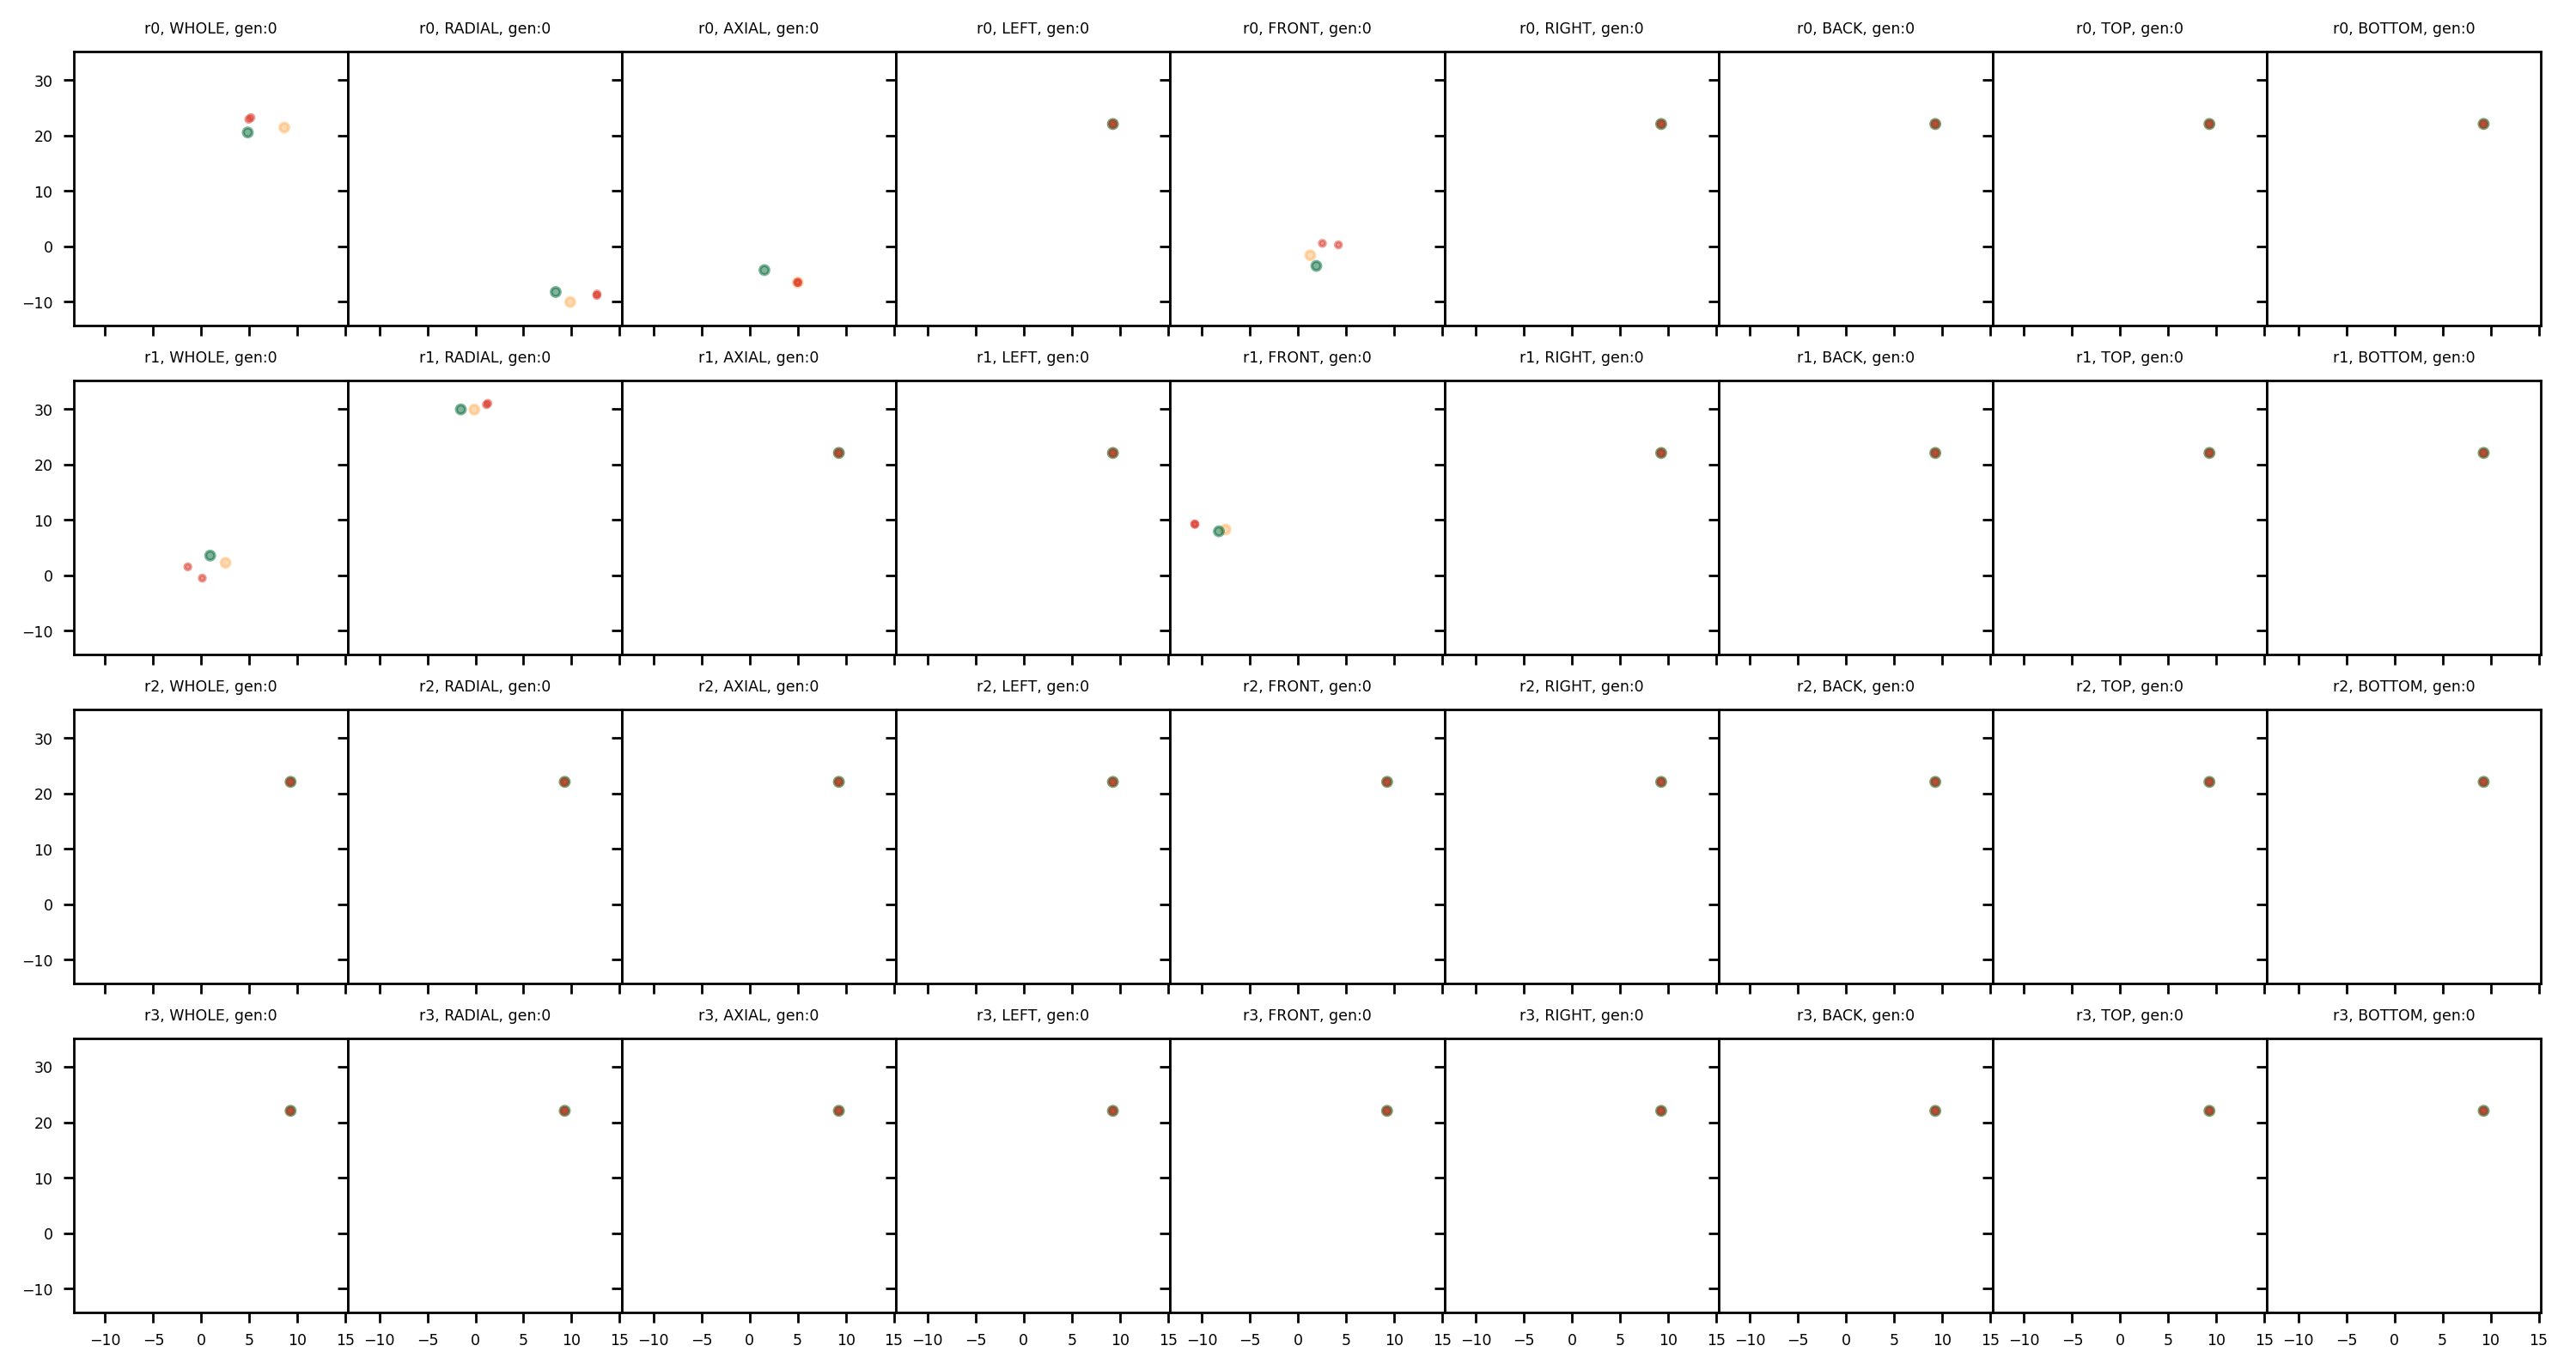

In [25]:
to_plot_embed = to_embed[-1]


umap_plotter = ctk.GridPlotter()
umap_plotter.add_2D_numeric_data(
    data_2d=to_plot_embed.get_2d_data(), 
    titles_2d=to_plot_embed.get_2d_titles(),
    global_ids_2d=to_plot_embed.get_2d_ids(),
)
umap_plotter.add_id_styling(ids=dot_ids, colors=dot_colors, sizes=dot_sizes, alphas=[0.5]*len(dot_ids))
umap_plotter.config.col_space = 0
umap_plotter.config.row_space = 0.2
umap_plotter.transpose()
umap_plotter.set_global_axis_limits(padding=0.1)

umap_plotter[:-1, :].set_xticklabels([])
umap_plotter[:, 1:].set_yticklabels([])
umap_plotter[:, 1:].set_yticklabels([])
umap_plotter.show()

1 RADIUS [pick], all spaces, show evolution

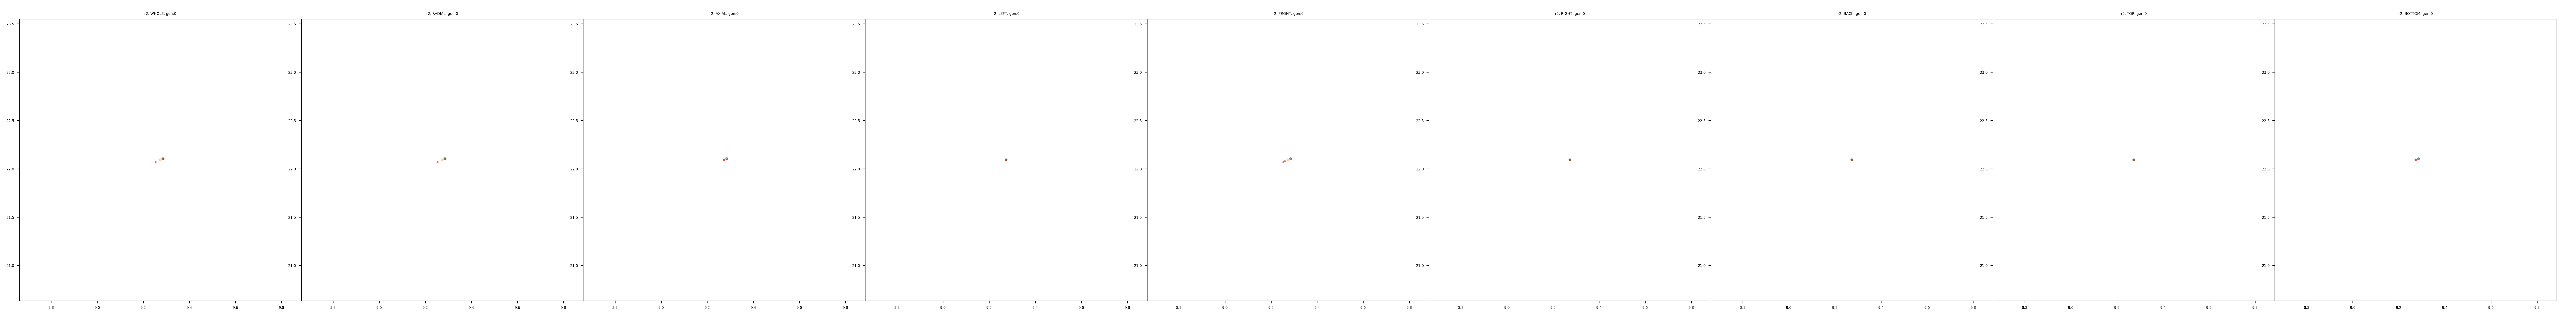

In [29]:
to_plot_embed = to_embed[2, :, :]


umap_plotter = ctk.GridPlotter()
umap_plotter.add_2D_numeric_data(
    data_2d=to_plot_embed.get_2d_data(), 
    titles_2d=to_plot_embed.get_2d_titles(),
    global_ids_2d=to_plot_embed.get_2d_ids(),
)
umap_plotter.add_id_styling(ids=dot_ids, colors=dot_colors, sizes=dot_sizes, alphas=[0.5]*len(dot_ids))
umap_plotter.config.col_space = 0
umap_plotter.config.row_space = 0.2
umap_plotter.transpose()
umap_plotter.set_global_axis_limits(padding=0.1)

# umap_plotter[:-1, :].set_xticklabels([])
# umap_plotter[:, 1:].set_yticklabels([])
# umap_plotter[:, 1:].set_yticklabels([])
umap_plotter.show()

### r [AGG]

In [30]:
to_fit_ragg = alive.map('to_cumulative', inplace=False)

grid = ctk.TransformerGrid(to_fit_ragg[0].grab_frame().shape)
umap = umap = ctk.UmapConfig(
    n_neighbors=5,
    random_state=None,
    transform_seed=None,
    n_jobs=-1
).get_umap()  
print(umap)
grid[:,:] = umap

{'n_neighbors': 5, 'n_components': 2, 'min_dist': 0.0, 'metric': 'cosine', 'random_state': None, 'init': 'random', 'transform_seed': None, 'n_jobs': -1}
UMAP(init='random', metric='cosine', min_dist=0.0, n_neighbors=5, transform_seed=None)


In [31]:
subset = to_fit_ragg.new_only(inplace=False)
subset.fit_grid(grid)

TransformerGrid(shape=(4, 9))

In [32]:
to_embed = to_fit_ragg[:, :, ::5]
to_embed.transform_grid(grid)

┏━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ IDX ┃  WHOLE  ┃ RADIAL  ┃  AXIAL  ┃   LEFT   ┃  FRONT  ┃  RIGHT   ┃  BACK   ┃   TOP    ┃ BOTTOM  ┃
┡━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│   0 │  [4×2]  │  [4×2]  │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │
│     │   Dn    │   Dn    │   Dn    │          │   Dn    │          │   Dn    │          │   Dn    │
│   1 │  [4×2]  │  [4×2]  │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │
│     │   Dn    │   Dn    │   Dn    │          │   Dn    │          │   Dn    │          │   Dn    │
│   2 │  [4×2]  │  [4×2]  │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │
│     │   Dn    │   Dn    │   Dn    │          │   Dn    │          │   Dn    │          │   Dn    │
│   3 │  [4×2]  │  [4×2]  │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │ 

1 GEN (start), all r [AGG], all spaces

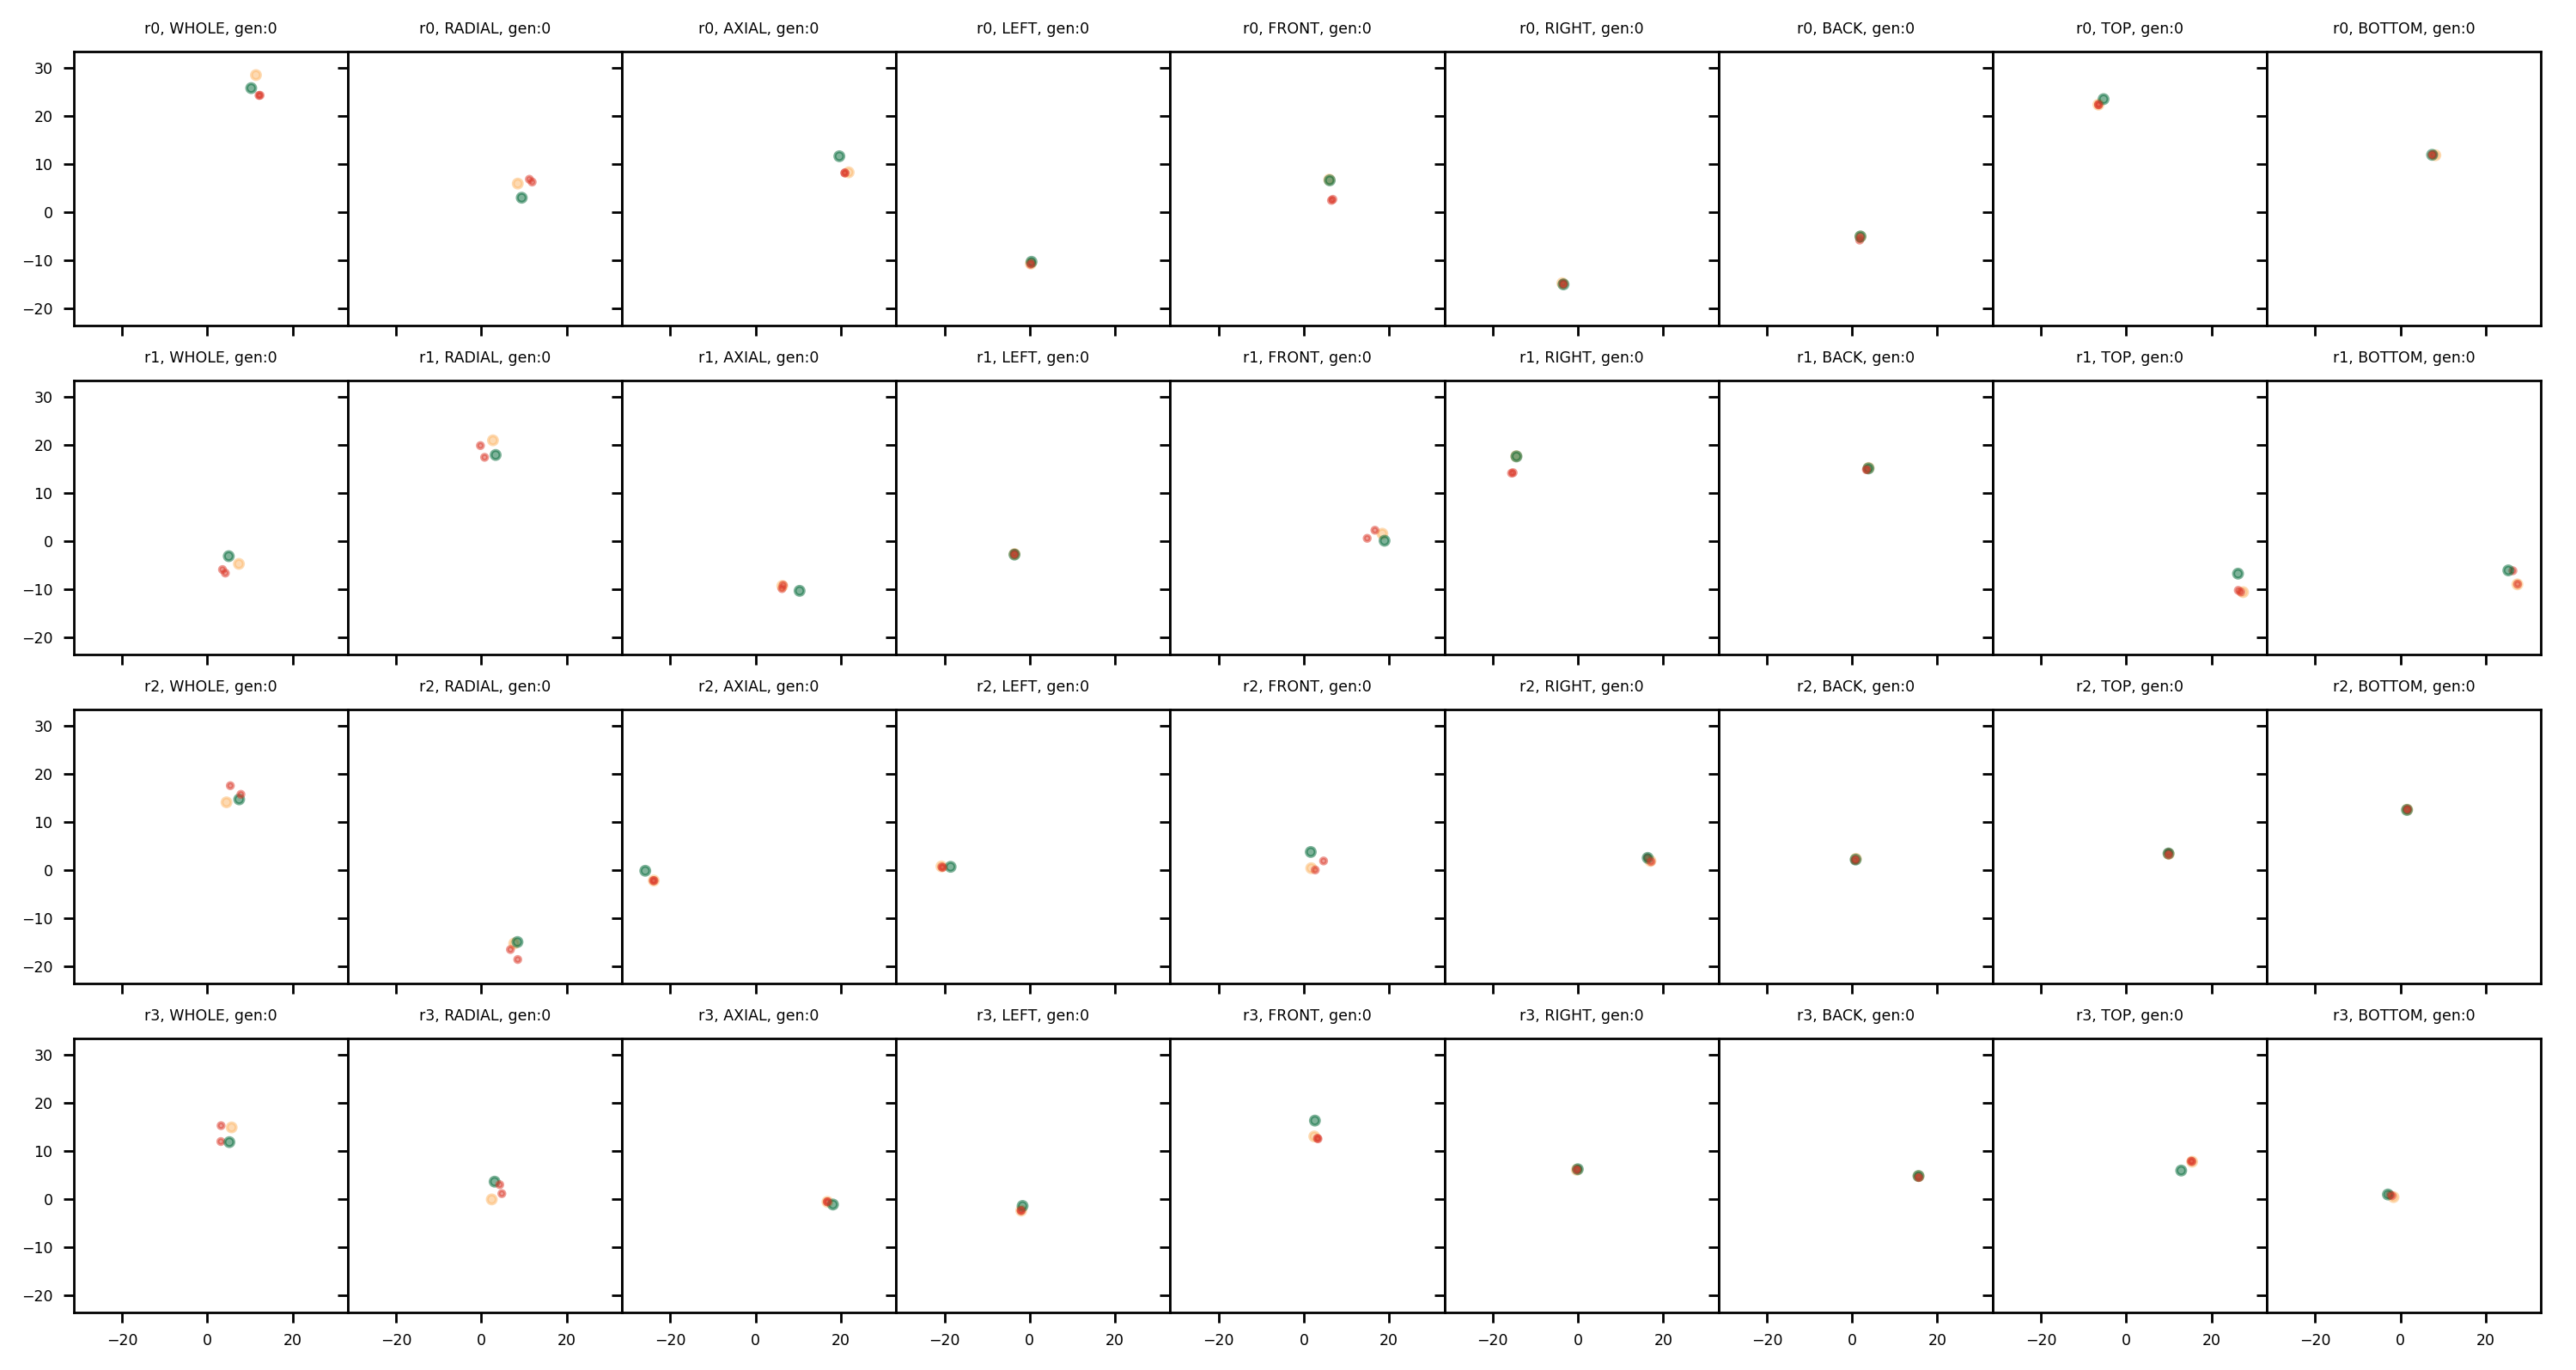

In [ ]:
to_plot_embed = to_embed[0]


umap_plotter = ctk.GridPlotter()
umap_plotter.add_2D_numeric_data(
    data_2d=to_plot_embed.get_2d_data(), 
    titles_2d=to_plot_embed.get_2d_titles(),
    global_ids_2d=to_plot_embed.get_2d_ids(),
)
umap_plotter.add_id_styling(ids=dot_ids, colors=dot_colors, sizes=dot_sizes, alphas=[0.5]*len(dot_ids))
umap_plotter.config.col_space = 0
umap_plotter.config.row_space = 0.2
umap_plotter.transpose()
umap_plotter.set_global_axis_limits(padding=0.1)

umap_plotter[:-1, :].set_xticklabels([])
umap_plotter[:, 1:].set_yticklabels([])
umap_plotter[:, 1:].set_yticklabels([])
umap_plotter.show()

1 GEN (end), all r [AGG], all spaces

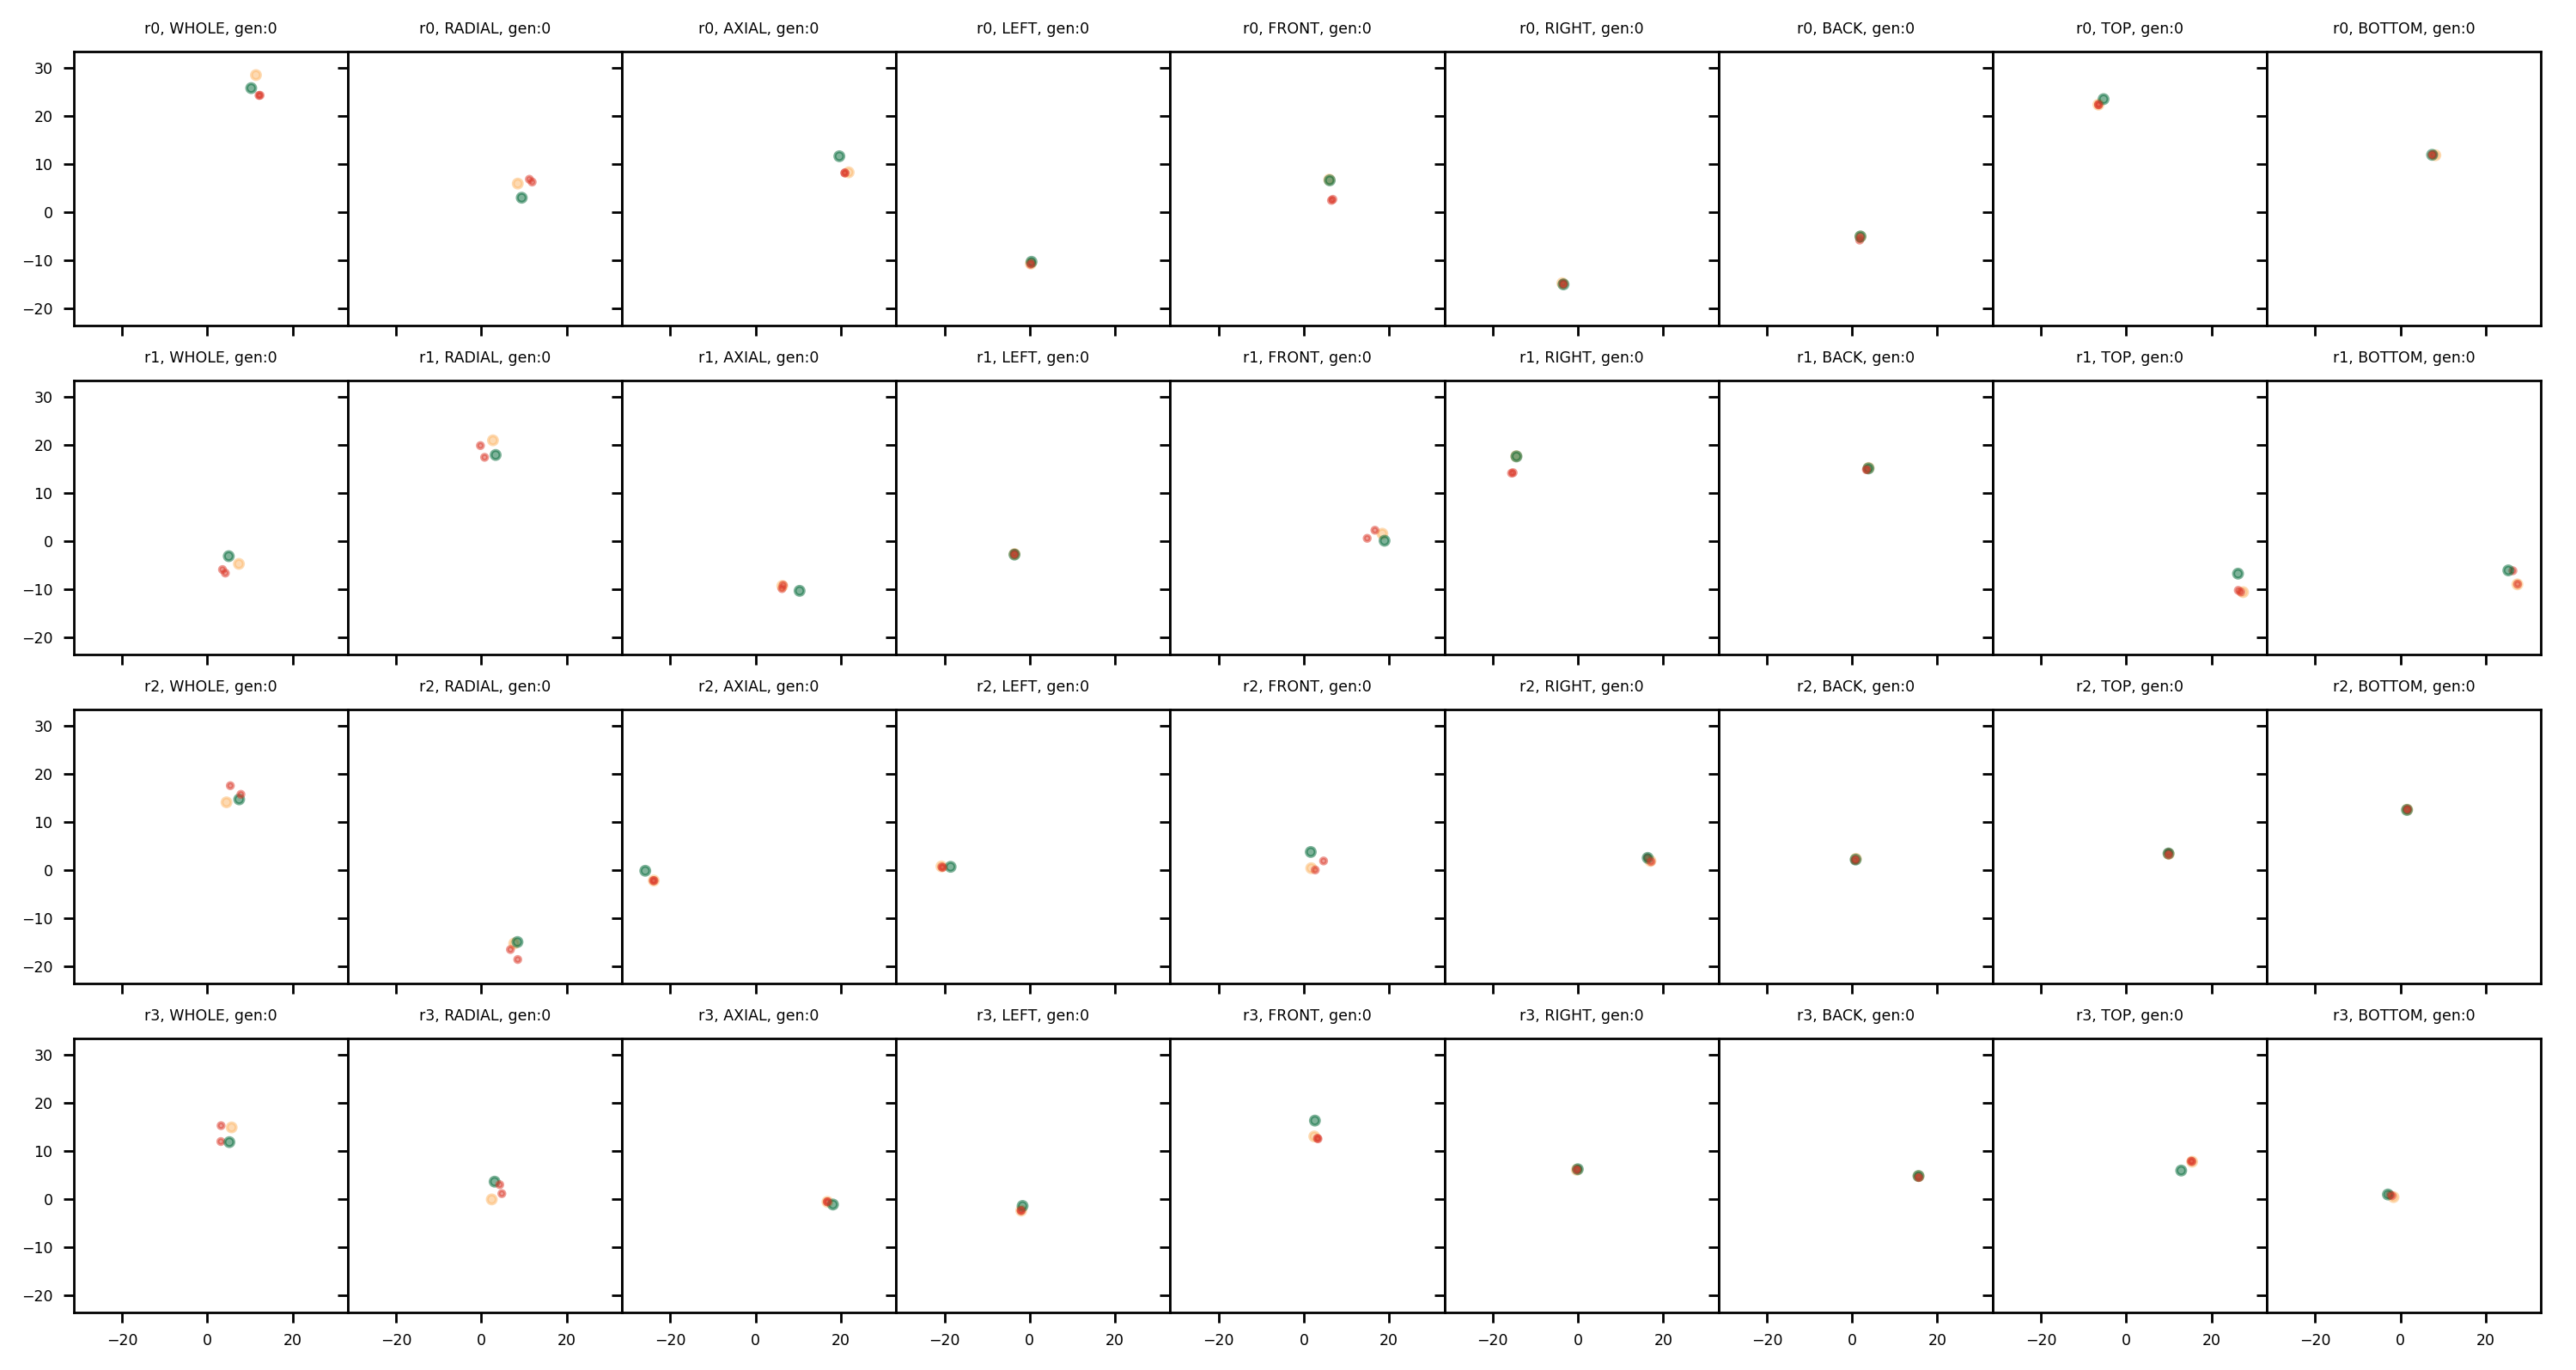

In [34]:
to_plot_embed = to_embed[-1]


umap_plotter = ctk.GridPlotter()
umap_plotter.add_2D_numeric_data(
    data_2d=to_plot_embed.get_2d_data(), 
    titles_2d=to_plot_embed.get_2d_titles(),
    global_ids_2d=to_plot_embed.get_2d_ids(),
)
umap_plotter.add_id_styling(ids=dot_ids, colors=dot_colors, sizes=dot_sizes, alphas=[0.5]*len(dot_ids))
umap_plotter.config.col_space = 0
umap_plotter.config.row_space = 0.2
umap_plotter.transpose()
umap_plotter.set_global_axis_limits(padding=0.1)

umap_plotter[:-1, :].set_xticklabels([])
umap_plotter[:, 1:].set_yticklabels([])
umap_plotter[:, 1:].set_yticklabels([])
umap_plotter.show()

1 r [AGG] [pick], all spaces, show evolution

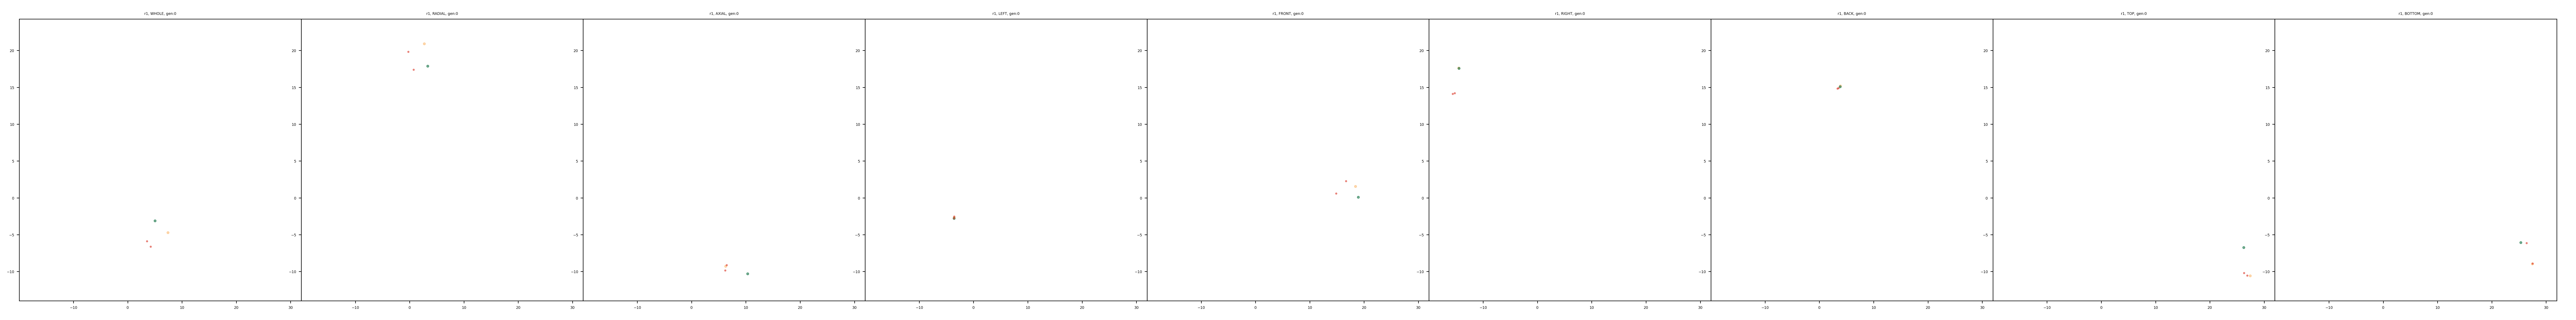

In [36]:
to_plot_embed = to_embed[1, :, ::5]


umap_plotter = ctk.GridPlotter()
umap_plotter.add_2D_numeric_data(
    data_2d=to_plot_embed.get_2d_data(), 
    titles_2d=to_plot_embed.get_2d_titles(),
    global_ids_2d=to_plot_embed.get_2d_ids(),
)
umap_plotter.add_id_styling(ids=dot_ids, colors=dot_colors, sizes=dot_sizes, alphas=[0.5]*len(dot_ids))
umap_plotter.config.col_space = 0
umap_plotter.config.row_space = 0.2
umap_plotter.transpose()
umap_plotter.set_global_axis_limits(padding=0.1)

# umap_plotter[:-1, :].set_xticklabels([])
# umap_plotter[:, 1:].set_yticklabels([])
# umap_plotter[:, 1:].set_yticklabels([])
umap_plotter.show()

### [AGG] spaces

In [37]:
to_fit_sagg = alive.replace().map('aggregate')[:, :, :]

grid = ctk.TransformerGrid(to_fit_sagg[0].grab_frame().shape)
umap = umap = ctk.UmapConfig(
    n_neighbors=5,
    random_state=None,
    transform_seed=None,
    n_jobs=-1
).get_umap()  
print(umap)
grid[:,:] = umap

print(to_fit_sagg)

{'n_neighbors': 5, 'n_components': 2, 'min_dist': 0.0, 'metric': 'cosine', 'random_state': None, 'init': 'random', 'transform_seed': None, 'n_jobs': -1}
UMAP(init='random', metric='cosine', min_dist=0.0, n_neighbors=5, transform_seed=None)
  ┏━━━━━┳━━━━━━━━━━━━━━━━━┓
┏━━━━━┳━━━━━━━━━━━━━━━━━┓ ┃
┃ IDX ┃   AGGREGATED    ┃ ┩
┡━━━━━╇━━━━━━━━━━━━━━━━━┩ │
│   0 │ [4×16777216] Sp │ │
│   1 │ [4×16777216] Sp │ │
│   2 │ [4×16777216] Sp │ │
│   3 │ [4×16777216] Sp │ ┘  ← gen 1 | 3
└─────┴─────────────────┘  ← gen 0
(4, 1, 2) | (4, 9, 2) (Original)


In [38]:
subset = to_fit_sagg.new_only(inplace=False)
subset.fit_grid(grid)

TransformerGrid(shape=(4, 1))

In [39]:
to_embed = to_fit_sagg[:, :, ::5]
to_embed.transform_grid(grid)

┏━━━━━┳━━━━━━━━━━━━┓
┃ IDX ┃ AGGREGATED ┃
┡━━━━━╇━━━━━━━━━━━━┩
│   0 │  [4×2] Dn  │
│   1 │  [4×2] Dn  │
│   2 │  [4×2] Dn  │
│   3 │  [4×2] Dn  │
└─────┴────────────┘ ← gen 0 | 3
(4, 1, 1) | (4, 9, 2) (Original)

1 GEN (start), all r, 1 [AGG] space

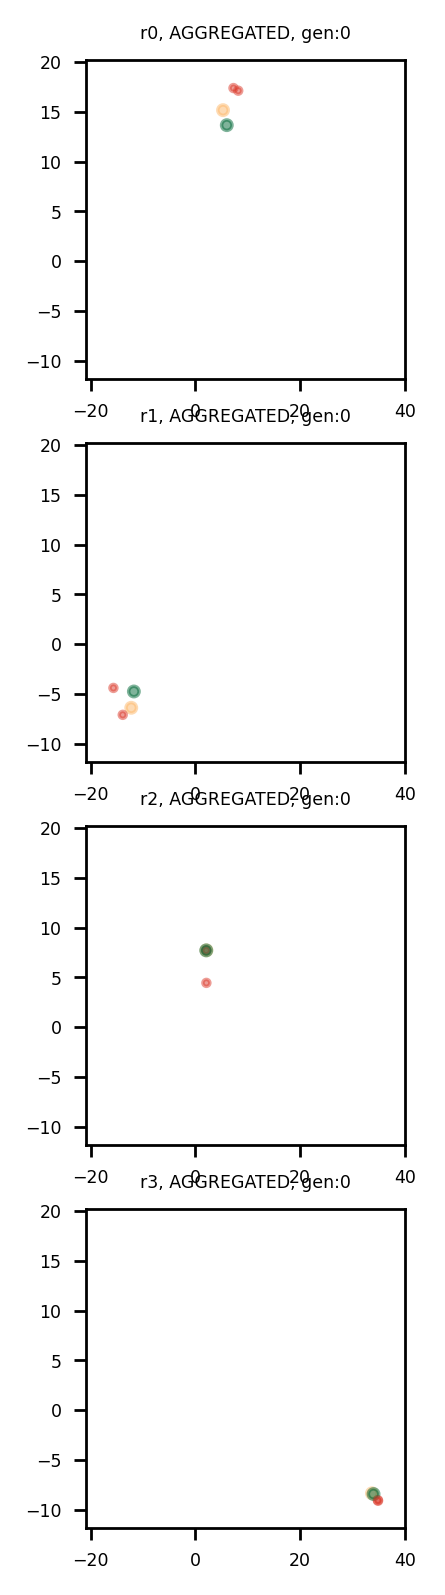

In [43]:
to_plot_embed = to_embed[0]


umap_plotter = ctk.GridPlotter()
umap_plotter.add_2D_numeric_data(
    data_2d=to_plot_embed.get_2d_data(), 
    titles_2d=to_plot_embed.get_2d_titles(),
    global_ids_2d=to_plot_embed.get_2d_ids(),
)
umap_plotter.add_id_styling(ids=dot_ids, colors=dot_colors, sizes=dot_sizes, alphas=[0.5]*len(dot_ids))
umap_plotter.config.col_space = 0
umap_plotter.config.row_space = 0.2
umap_plotter.transpose()
umap_plotter.set_global_axis_limits(padding=0.1)

# umap_plotter[:-1, :].set_xticklabels([])
# umap_plotter[:, 1:].set_yticklabels([])
# umap_plotter[:, 1:].set_yticklabels([])
umap_plotter.show()

1 GEN (start), all r, 1 [AGG] space

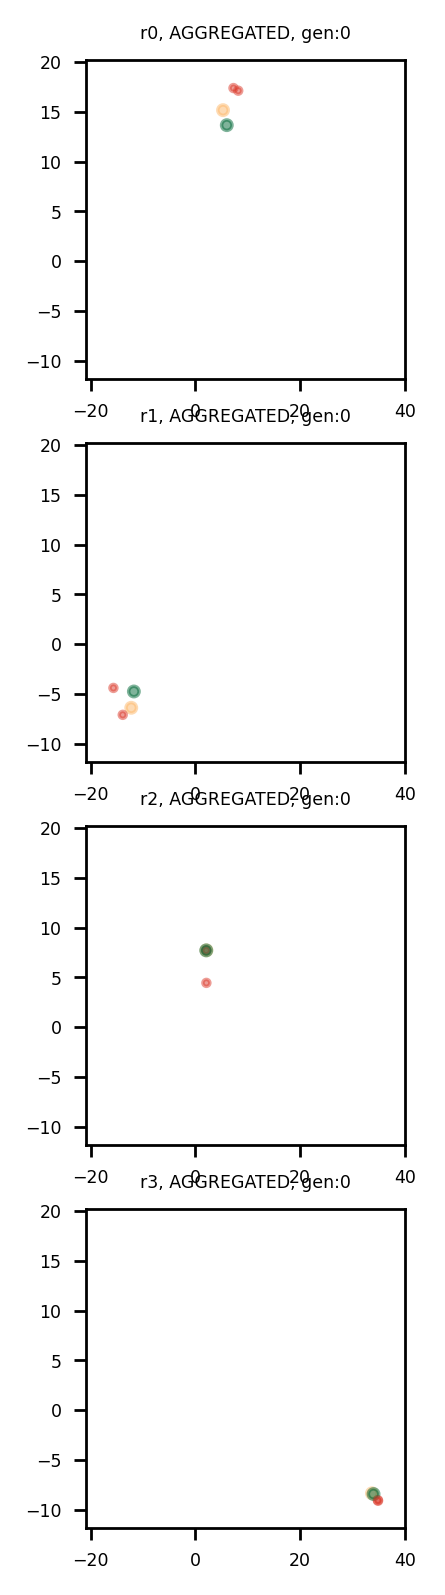

In [45]:
to_plot_embed = to_embed[-1]

umap_plotter = ctk.GridPlotter()
umap_plotter.add_2D_numeric_data(
    data_2d=to_plot_embed.get_2d_data(), 
    titles_2d=to_plot_embed.get_2d_titles(),
    global_ids_2d=to_plot_embed.get_2d_ids(),
)
umap_plotter.add_id_styling(ids=dot_ids, colors=dot_colors, sizes=dot_sizes, alphas=[0.5]*len(dot_ids))
umap_plotter.config.col_space = 0
umap_plotter.config.row_space = 0.2
umap_plotter.transpose()
umap_plotter.set_global_axis_limits(padding=0.1)

# umap_plotter[:-1, :].set_xticklabels([])
# umap_plotter[:, 1:].set_yticklabels([])
# umap_plotter[:, 1:].set_yticklabels([])
umap_plotter.show()

all r, 1 space [agg], show evolution

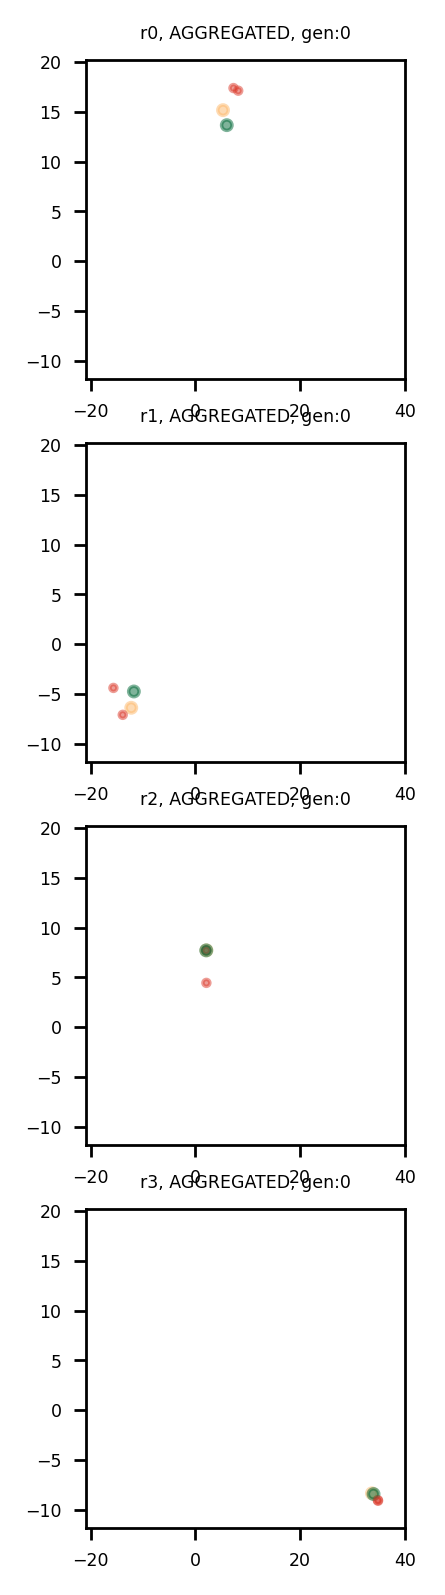

In [47]:
to_plot_embed = to_embed[:, 0, ::5]

umap_plotter = ctk.GridPlotter()
umap_plotter.add_2D_numeric_data(
    data_2d=to_plot_embed.get_2d_data(), 
    titles_2d=to_plot_embed.get_2d_titles(),
    global_ids_2d=to_plot_embed.get_2d_ids(),
)
umap_plotter.add_id_styling(ids=dot_ids, colors=dot_colors, sizes=dot_sizes, alphas=[0.5]*len(dot_ids))
umap_plotter.config.col_space = 0
umap_plotter.config.row_space = 0.2
umap_plotter.transpose()
umap_plotter.set_global_axis_limits(padding=0.1)

# umap_plotter[:-1, :].set_xticklabels([])
# umap_plotter[:, 1:].set_yticklabels([])
# umap_plotter[:, 1:].set_yticklabels([])
umap_plotter.show()

In [48]:
to_fit_ragg = alive.map('to_cumulative', inplace=False)

grid = ctk.TransformerGrid(to_fit_ragg[0].grab_frame().shape)
umap = umap = ctk.UmapConfig(
    n_neighbors=5,
    random_state=None,
    transform_seed=None,
    n_jobs=-1
).get_umap()  
print(umap)
grid[:,:] = umap

{'n_neighbors': 5, 'n_components': 2, 'min_dist': 0.0, 'metric': 'cosine', 'random_state': None, 'init': 'random', 'transform_seed': None, 'n_jobs': -1}
UMAP(init='random', metric='cosine', min_dist=0.0, n_neighbors=5, transform_seed=None)


In [49]:
subset = to_fit_ragg.new_only(inplace=False)
subset.fit_grid(grid)

TransformerGrid(shape=(4, 9))

In [50]:
to_embed = to_fit_ragg[:, :, ::5]
to_embed.transform_grid(grid)

┏━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ IDX ┃  WHOLE  ┃ RADIAL  ┃  AXIAL  ┃   LEFT   ┃  FRONT  ┃  RIGHT   ┃  BACK   ┃   TOP    ┃ BOTTOM  ┃
┡━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│   0 │  [4×2]  │  [4×2]  │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │
│     │   Dn    │   Dn    │   Dn    │          │   Dn    │          │   Dn    │          │   Dn    │
│   1 │  [4×2]  │  [4×2]  │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │
│     │   Dn    │   Dn    │   Dn    │          │   Dn    │          │   Dn    │          │   Dn    │
│   2 │  [4×2]  │  [4×2]  │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │
│     │   Dn    │   Dn    │   Dn    │          │   Dn    │          │   Dn    │          │   Dn    │
│   3 │  [4×2]  │  [4×2]  │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │  [4×2]  │ [4×2] Dn │ 

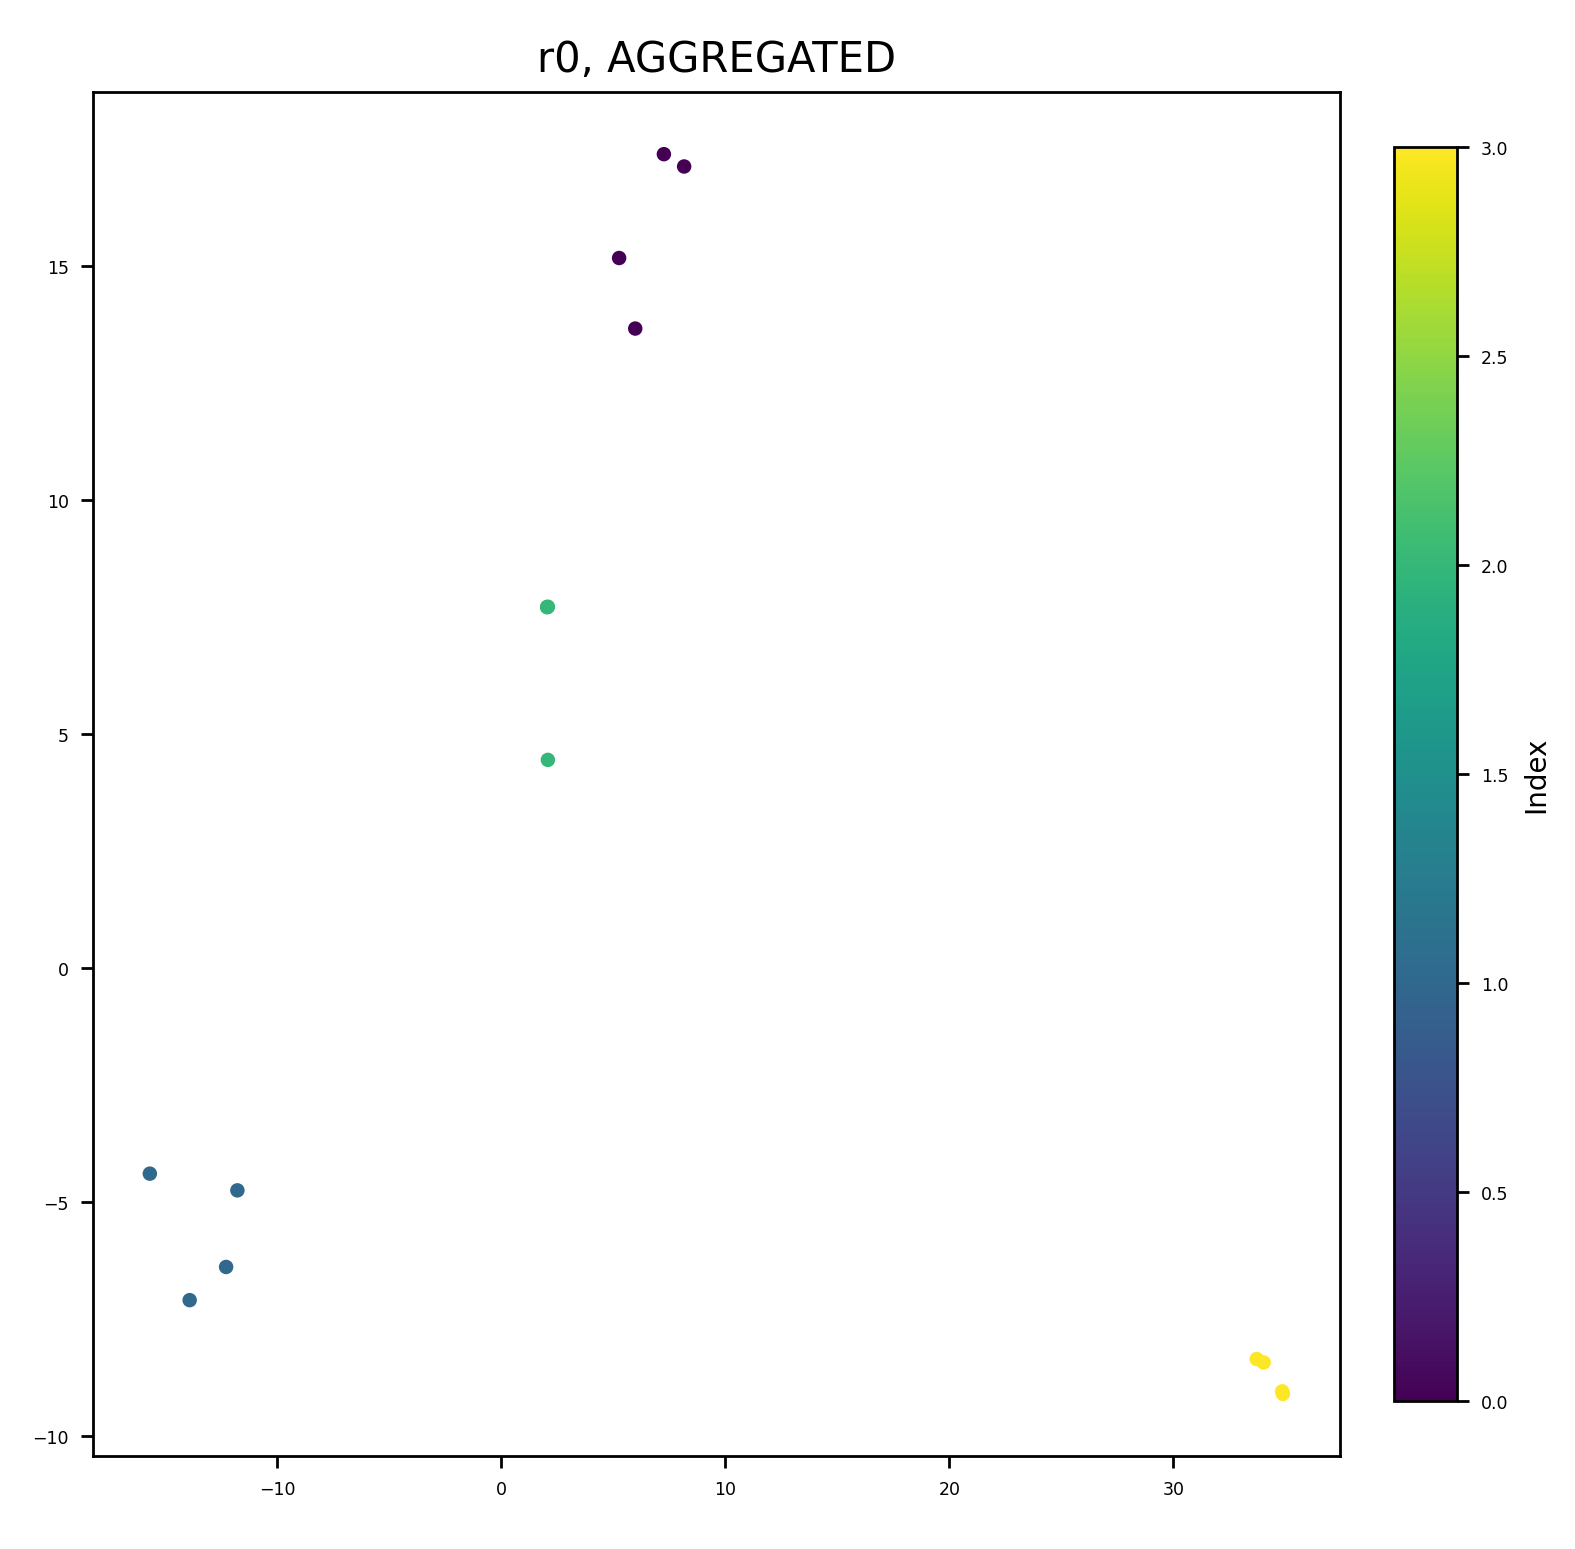

Successfully saved GIF: __data__/run_0010/r0__aggregated.gif


In [51]:
umap_plotter = ctk.GridPlotter()
umap_plotter.add_collapsed_data(
    data=to_plot_embed.get_2d_data(), 
    title=to_plot_embed.get_2d_titles()[0][0][:-7]
)
umap_plotter.show()
umap_plotter.to_gif(filepath=f"{config.OUTPUT_FOLDER}/{to_plot_embed.get_2d_titles()[0][0][:-7].strip().lower().replace(',', '_').replace(' ', '_')}.gif")

### r [AGG] space [AGG]

In [52]:
to_fit_rsagg = alive.map('aggregate').map('aggregate')

grid = ctk.TransformerGrid(to_fit_rsagg[0].grab_frame().shape)
umap = umap = ctk.UmapConfig(
    n_neighbors=5,
    random_state=None,
    transform_seed=None,
    n_jobs=-1
).get_umap()  
print(umap)
grid[:,:] = umap

{'n_neighbors': 5, 'n_components': 2, 'min_dist': 0.0, 'metric': 'cosine', 'random_state': None, 'init': 'random', 'transform_seed': None, 'n_jobs': -1}
UMAP(init='random', metric='cosine', min_dist=0.0, n_neighbors=5, transform_seed=None)


In [53]:
subset = to_fit_rsagg.new_only(inplace=False)
subset.fit_grid(grid)

TransformerGrid(shape=(1, 1))

In [54]:
to_embed = to_fit_rsagg[:, :, ::5]
to_embed.transform_grid(grid)

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ IDX ┃ AGGREGATED_AGGREGATED ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│   3 │       [4×2] Dn        │
└─────┴───────────────────────┘ ← gen 0 | 3
(1, 1, 1) | (4, 9, 2) (Original)

1 r [agg], 1 space [agg] show evolution

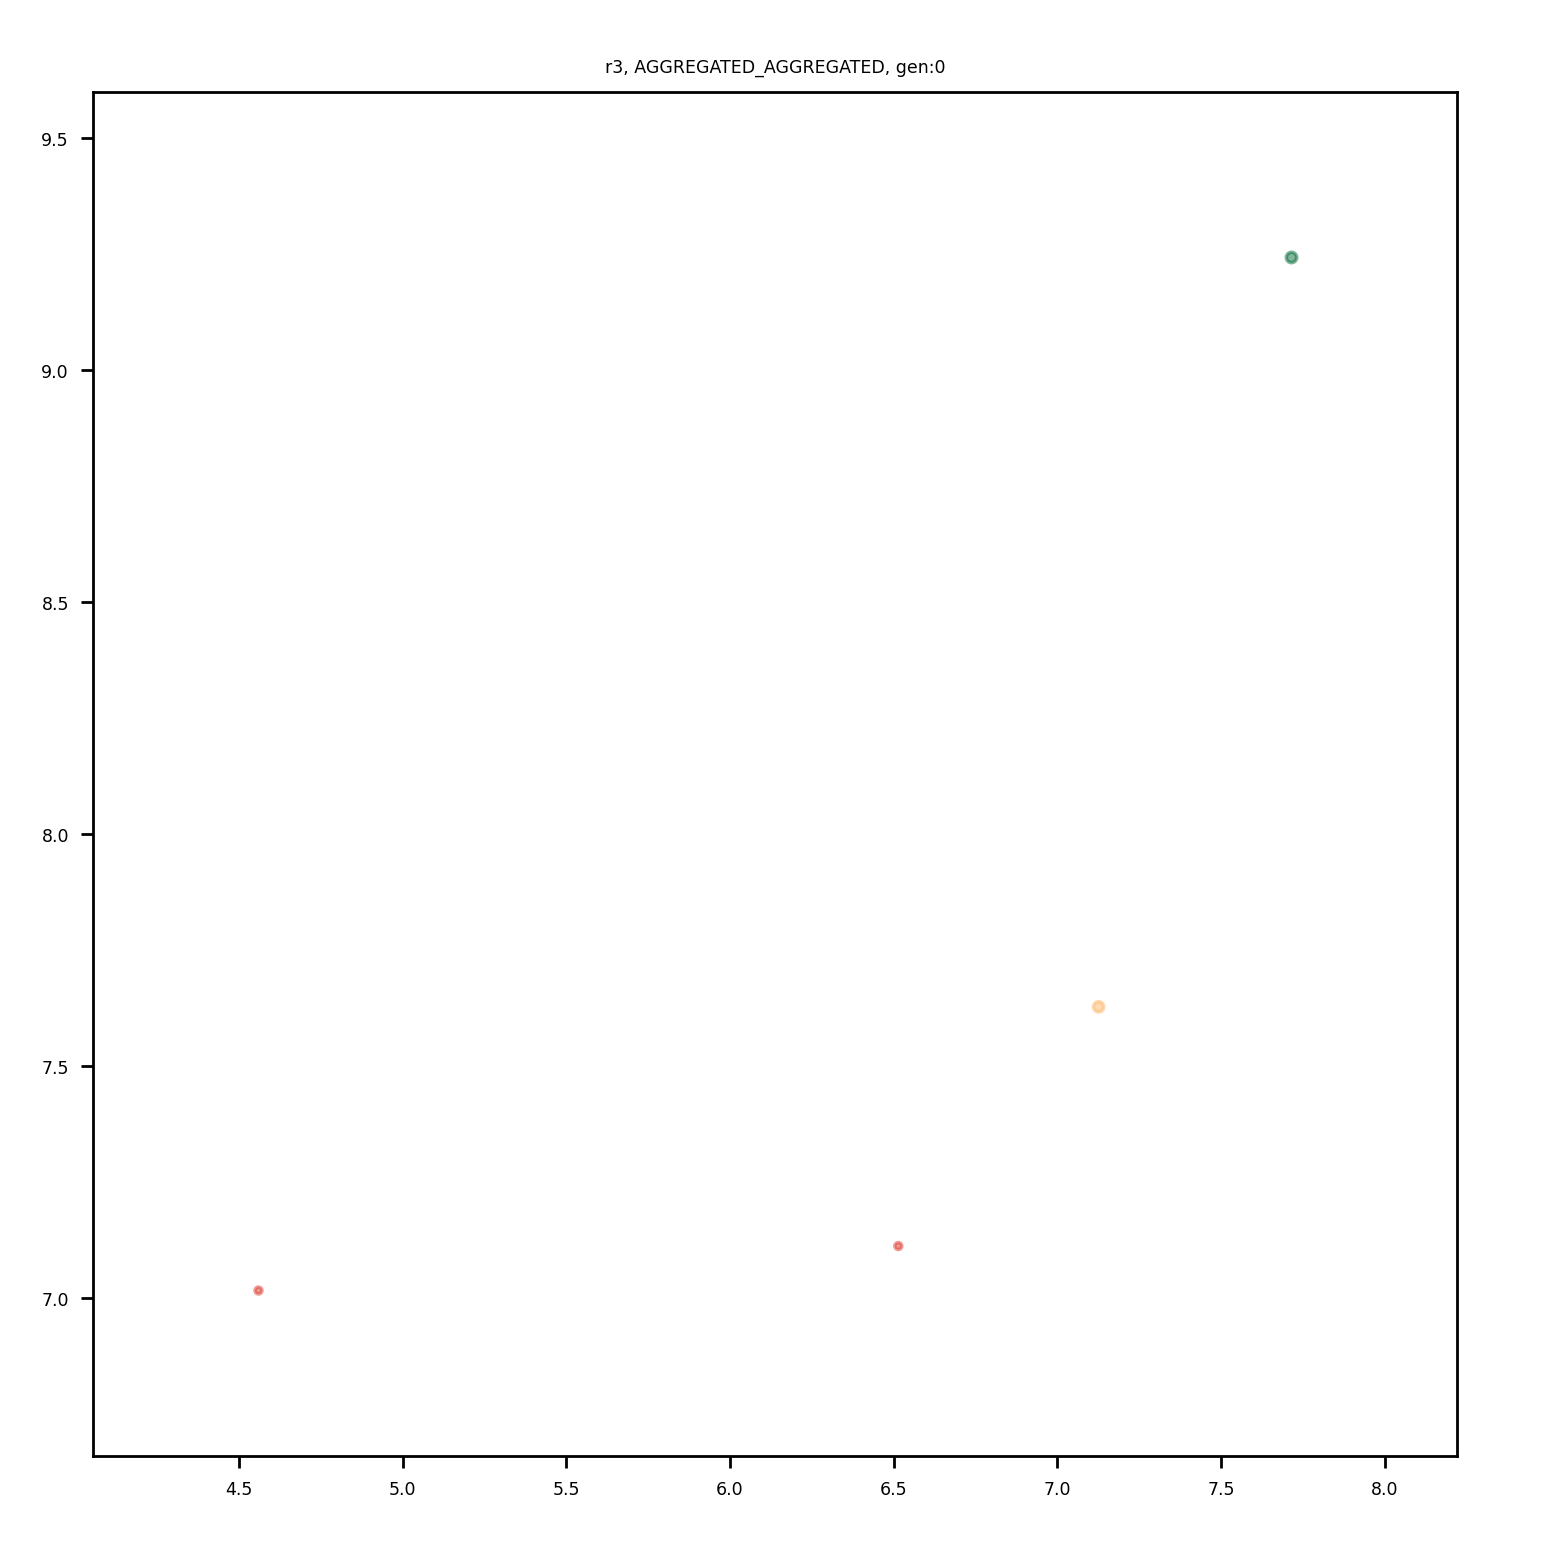

In [56]:
to_plot_embed = to_embed[:, :, ::5]

umap_plotter = ctk.GridPlotter()
umap_plotter.add_2D_numeric_data(
    data_2d=to_plot_embed.get_2d_data(), 
    titles_2d=to_plot_embed.get_2d_titles(),
    global_ids_2d=to_plot_embed.get_2d_ids(),
)
umap_plotter.add_id_styling(ids=dot_ids, colors=dot_colors, sizes=dot_sizes, alphas=[0.5]*len(dot_ids))
umap_plotter.config.col_space = 0
umap_plotter.config.row_space = 0.2
umap_plotter.transpose()
umap_plotter.set_global_axis_limits(padding=0.1)

# umap_plotter[:-1, :].set_xticklabels([])
# umap_plotter[:, 1:].set_yticklabels([])
# umap_plotter[:, 1:].set_yticklabels([])
umap_plotter.show()

show evolution in 1 image

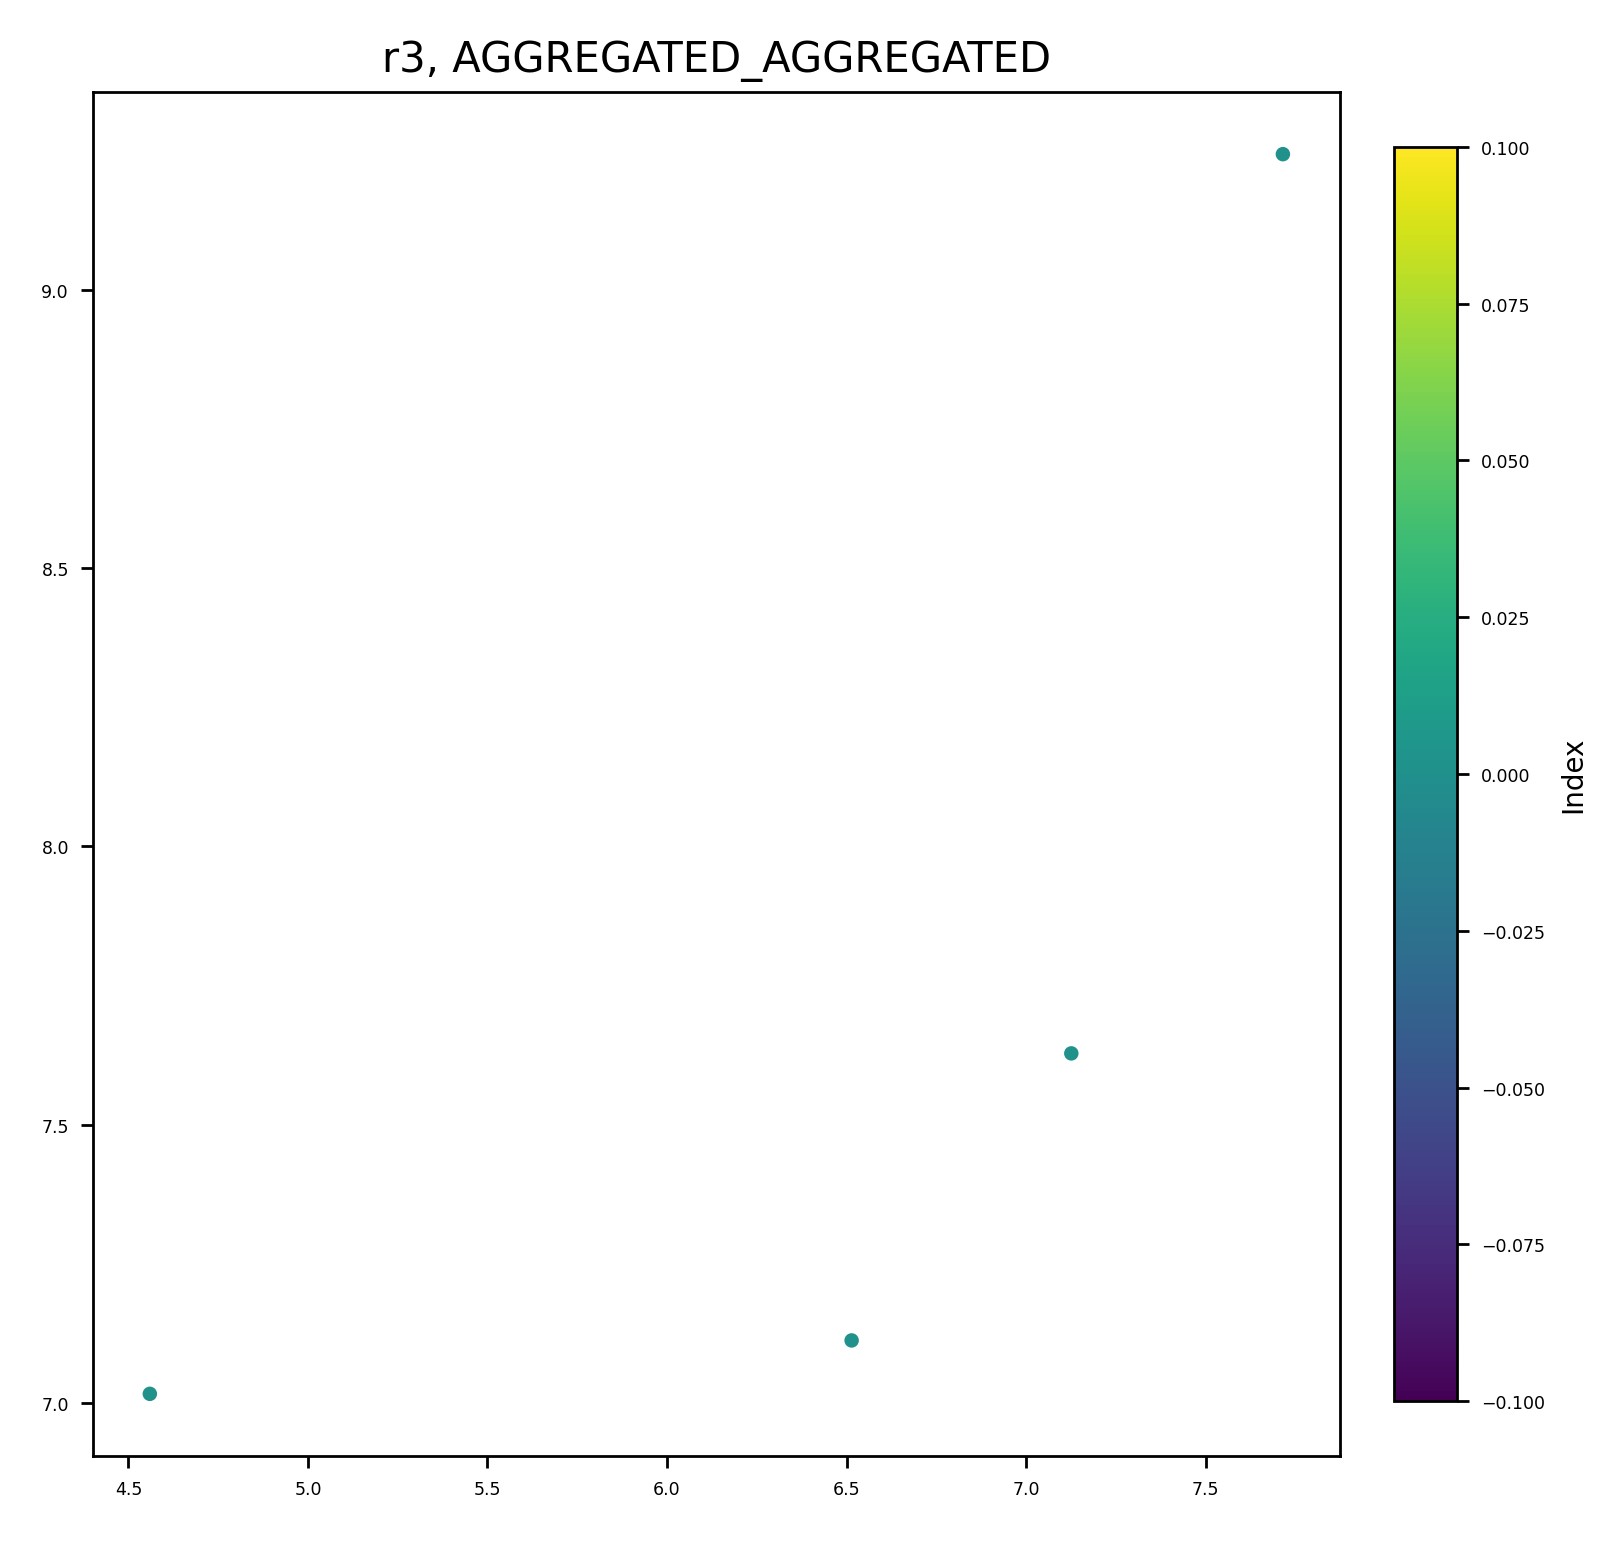

Successfully saved GIF: __data__/run_0010/r3__aggregated_aggregated.gif


In [57]:
umap_plotter = ctk.GridPlotter()
umap_plotter.add_collapsed_data(
    data=to_plot_embed.get_2d_data(), 
    title=to_plot_embed.get_2d_titles()[0][0][:-7]
)
umap_plotter.show()
umap_plotter.to_gif(filepath=f"{config.OUTPUT_FOLDER}/{to_plot_embed.get_2d_titles()[0][0][:-7].strip().lower().replace(',', '_').replace(' ', '_')}.gif")